# PAM GtACR1, starved flies

In [624]:
import numpy as np
import os
import time
import scipy
import glob
import sys
from datetime import datetime
import matplotlib as mpl
mpl.use('nbagg')
import seaborn as sns
import pylab as pl

import importlib
import pandas as pd
import scipy.stats as spstats

# import some custom funcs
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import utils as util
import behavior as butil
import plotting as putil
import google_drive as gdrive

from matplotlib.gridspec import GridSpec



In [2]:
importlib.reload(util)
util.set_sns_style(style='dark')
%matplotlib notebook

In [3]:
# if util.get_os() == 'Linux':
#     rootdir = '/home/julianarhee/edgetracking-googledrive/Edge_Tracking/Data'
# elif util.get_os() == 'Darwin':
#     rootdir = '/home/julianarhee/Library/CloudStorage/GoogleDrive-edge.tracking.ru@gmail.com/My Drive/Edge_Tracking/Data'
# else:
#     rootdir=None
#     print("Unknown os: {}".format(util.get_os()))
rootdir = util.get_rootdir()
experiment = 'PAM_GtACR1'

src_dir = os.path.join(rootdir, experiment)
# # src_dir = '/Users/julianarhee/Documents/rutalab/data/test'
# print(src_dir)
fig_id = os.path.join('/Edge_Tracking', rootdir.split('/Edge_Tracking/')[1], experiment)
print(fig_id)
savedir = '{}/jyr/{}'.format(rootdir, experiment)
savedir = savedir.replace(" ", "")
figdir = os.path.join(savedir, 'figures')
print("Saving figures to:{}    {}".format('\n', figdir))
if not os.path.exists(figdir):
    os.makedirs(figdir)

/Edge_Tracking/Data/PAM_GtACR1
Saving figures to:
    /home/julianarhee/edgetracking-googledrive/Edge_Tracking/Data/jyr/PAM_GtACR1/figures


In [4]:
select_logs = [
    '10292021-142308_PAMGTACR1_thresh_lights_LT_Fly2_002.log',
    '10292021-143856_PAMGTACR1_thresh_lights_LT_Fly2_003.log',
    '11102021_Fly1/11102021-104614_PAMGtACR1_thresh_lights_old_food_yeast_Fly1_001.log',
    '11102021-110114_PAMGTACR1_thresh_lights_old_food_yeast_Fly1_002.log',
    '11102021-134854_PAMGtACR1_thresh_lights_old_food_yeast_Fly2_001.log',
    '11102021-140908_PAMGtACR1_thresh_lights_old_food_yeast_Fly2_002.log',
    '11122021-151822_PAMGtACR1_Fly1_001.log',
    '11122021-151822_PAMGtACR1_Fly1_001.log',
    '11152021-150321_PAMGtACR1_Fly1_002.log',
    '11152021-153105_PAMGtACR1_Fly1_003.log',
    '11162021-104332_PAMGTACR1_Fly1_001.log',
    '11162021-105012_PAMGtACR1_Fly1_002.log',
]

In [5]:
importlib.reload(butil)

<module 'behavior' from '/home/julianarhee/Repositories/plume-tracking/behavior.py'>

In [6]:
importlib.reload(gdrive)

<module 'google_drive' from '/home/julianarhee/Repositories/plume-tracking/google_drive.py'>

#### GtACR1 has specified files from Andy

In [7]:
print(experiment)
loginfo_fpath = os.path.join(savedir, 'info.pkl')

if os.path.exists(loginfo_fpath):
    logdf = gdrive.load_gdrive_df(loginfo_fpath)
else:
    logdf = gdrive.get_info_from_gsheet(experiment)
logdf.shape

PAM_GtACR1


(62, 6)

In [8]:
logdf.head()

fly      date experiment                                                log  \
0   1  20211026     inside  10262021-113334_PAMGtACR1_thresh_lights_on_Fly...   
1   1  20211026       none  10262021-114313_PAMGTACR1_thresh_no_lights_Fly...   
2   1  20211026    outisde  10262021-120011_PAMGtACR1_lights_outside_Fly1_...   
3   1  20211026       none      10262021-125040_PAMGtACR1_no_lights_strip.log   
4   2  20211027       none   10272021-150422_PAMGtACR1_no_lights_Fly1_001.log   

   mfc                                           filepath  
0  new  /home/julianarhee/edgetracking-googledrive/Edg...  
1  new  /home/julianarhee/edgetracking-googledrive/Edg...  
2  new  /home/julianarhee/edgetracking-googledrive/Edg...  
3  new  /home/julianarhee/edgetracking-googledrive/Edg...  
4  new  /home/julianarhee/edgetracking-googledrive/Edg...

## safe copy to my folder

In [9]:
copy_files=False
# -------------------------------------------------------------------------
if copy_files:
    import shutil
    if not os.path.exists(os.path.join(savedir, 'raw')):
        os.makedirs(os.path.join(savedir, 'raw'))
    for fpath in logdf['filepath'].values:
        fbase = os.path.split(fpath)[-1]
        shutil.copy(fpath, os.path.join(savedir, 'raw', fbase))

src_dir = os.path.join(savedir, 'raw')
len(sorted(os.listdir(src_dir), key=util.natsort))


63

## get filepaths to raw log

In [10]:
if 'filepath' not in logdf.columns:
    print("Finding filepaths...")
    logdf['filepath'] = None
    #curr_fns = logdf[logdf['experiment']=='inside']['log'].values
    curr_fns = logdf['log'].values
    for fn in curr_fns:
        found_files=[]
        print(fn)
        try:
            found_files = glob.glob(os.path.join(src_dir, '*/*/{}'.format(fn)))
            assert len(found_files)==1, "No file found, checking one dir up."
        except AssertionError as e:
            found_files = glob.glob(os.path.join(src_dir, '*/{}'.format(fn)))
            assert len(found_files)==1, "No file found: {}.".format(fn)
        if len(found_files)==1:
            logdf.loc[logdf['log']==fn, 'filepath'] = found_files[0] 

    # save
    import _pickle as pkl
    gdrive.save_gdrive_df(logdf, loginfo_fpath)


## check LED activation inside/outside

In [174]:
fn = '10292021-142308_PAMGTACR1_thresh_lights_LT_Fly2_002.log'
fpath = os.path.join(src_dir, fn)
df0 = pd.read_csv(fpath, encoding='latin' )
df_ = butil.load_dataframe(fpath, experiment=experiment)
df_ = butil.correct_manual_conditions(df_, experiment, logdf=logdf)
df_ = butil.process_df(df_)
print(df0.columns)

[WARNING] ['10292021-142308_PAMGTACR1_thresh_lights_LT_Fly2_002']: Found bad skips, removing 175 of 30959 samples.
Correcting experiment conditions: PAM_GtACR1
Index(['timestamp -- motor_step_command', 'mfc1_stpt', 'mfc2_stpt',
       'mfc3_stpt', 'led1_stpt', 'led2_stpt', 'sig_status', 'ft_posx',
       'ft_posy', 'ft_frame', 'ft_error', 'ft_roll', 'ft_pitch', 'ft_yaw',
       'ft_heading', 'instrip'],
      dtype='object')


In [178]:
df_['date'].unique()

array([20211029])

<IPython.core.display.Javascript object>


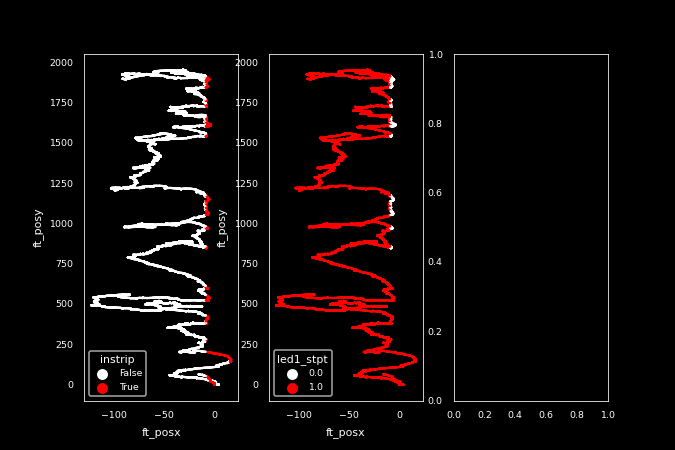

<IPython.core.display.Javascript object>


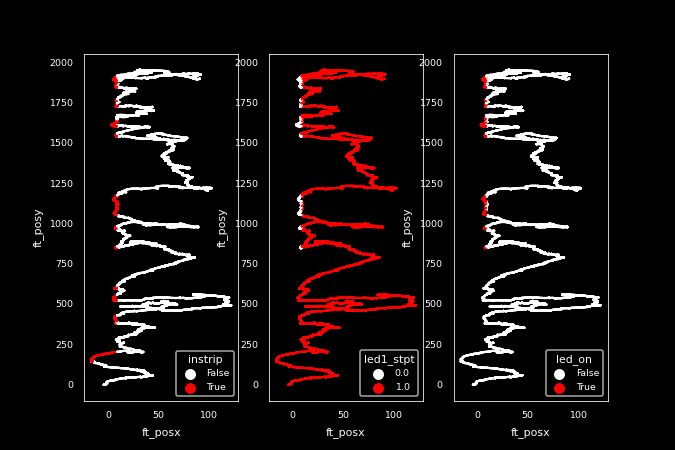

<AxesSubplot: xlabel='ft_posx', ylabel='ft_posy'>

In [175]:
fig, axn = pl.subplots(1,3)
sns.scatterplot(data=df0, x='ft_posx', y='ft_posy', hue='instrip', ax=axn[0],
                palette={True: 'r', False: 'w'}, s=2, edgecolor='none')
sns.scatterplot(data=df0, x='ft_posx', y='ft_posy', hue='led1_stpt', ax=axn[1],
                palette={True: 'r', False: 'w'}, s=2, edgecolor='none')

fig, axn = pl.subplots(1,3)
sns.scatterplot(data=df_, x='ft_posx', y='ft_posy', hue='instrip', ax=axn[0],
                palette={True: 'r', False: 'w'}, s=2, edgecolor='none')
sns.scatterplot(data=df_, x='ft_posx', y='ft_posy', hue='led1_stpt', ax=axn[1],
                palette={True: 'r', False: 'w'}, s=2, edgecolor='none')
sns.scatterplot(data=df_, x='ft_posx', y='ft_posy', hue='led_on', ax=axn[2],
                palette={True: 'r', False: 'w'}, s=2, edgecolor='none')

# Get combined df

In [ ]:
create_new=False
strip_width=50
strip_sep=1000
# ---------------------------------
log_files = butil.get_log_files(src_dir=src_dir, experiment=experiment, verbose=False, is_gdrive=False,
                        return_loginfo=False)
# is_csv = False
df0_all = butil.load_combined_df(log_files=log_files, logdf=logdf, src_dir=src_dir,
                                is_csv=False, experiment=experiment, 
                                savedir=savedir, save_errors=False, create_new=create_new,
                                parse_filename=True, remove_invalid=True, process=True)
#df0_all = df0_all.reset_index(drop=True)
# Make some fixes
df0_all.loc[df0_all['condition']=='outisde', 'condition'] = 'outside'
df0_all.loc[df0_all['condition']=='inisde', 'condition'] = 'inside'
# 1 mistaken condition (based on LED activation pattern):
df0_all.loc[df0_all['filename']=='10272021-164059_PAMGTACR1_thresh_lights_on_inside_LT_Fly1_009', 'condition'] = 'outside'

exclude = [
    '10262021-125040_PAMGtACR1_no_lights_strip', 
    '10262021-120011_PAMGtACR1_lights_outside_Fly1_003',
    '11162021-161133_PAMGtACR1_Fly3_006', 
    '11122021-165711_PAMGtACR1_Fly1_008'
]

condition_list = df0_all['condition'].unique()
print("Found {} conditions:".format(len(condition_list)))
for c in condition_list:
    print(c)

if create_new: # save
    df_fpath = os.path.join(savedir, 'combined_df.pkl')
    print("Saving combined df to: {}".format(savedir))
    butil.save_df(df0_all, df_fpath)
create_new=False

Checking parent dir.
Found 63 tracking files.
loading existing combined df


In [11]:
df_fpath = os.path.join(savedir, 'combined_df.pkl')
df0_all = butil.load_df(df_fpath)

In [13]:
print("There are {} unique fly IDs.".format(len(df0_all['fly_id'].unique())))
df0_all['fly_id'].unique()

There are 14 unique fly IDs.


array(['20211026-fly1', '20211027-fly2', '20211028-fly3', '20211028-fly4',
       '20211029-fly6', '20211029-fly5', '20211110-fly14',
       '20211110-fly13', '20211112-fly12', '20211115-fly11',
       '20211116-fly10', '20211116-fly8', '20211116-fly9',
       '20211118-fly7'], dtype=object)

In [14]:
included_conditions = 'all' #'selected':
# ----------------------------------------------------------------
# from andy:
select_logs = [
    '10292021-142308_PAMGTACR1_thresh_lights_LT_Fly2_002.log',
    '10292021-143856_PAMGTACR1_thresh_lights_LT_Fly2_003.log',
    '11102021_Fly1/11102021-104614_PAMGtACR1_thresh_lights_old_food_yeast_Fly1_001.log',
    '11102021-110114_PAMGTACR1_thresh_lights_old_food_yeast_Fly1_002.log',
    '11102021-134854_PAMGtACR1_thresh_lights_old_food_yeast_Fly2_001.log',
    '11102021-140908_PAMGtACR1_thresh_lights_old_food_yeast_Fly2_002.log',
    '11122021-151822_PAMGtACR1_Fly1_001.log',
    '11122021-151822_PAMGtACR1_Fly1_001.log',
    '11152021-150321_PAMGtACR1_Fly1_002.log',
    '11152021-153105_PAMGtACR1_Fly1_003.log',
    '11162021-104332_PAMGTACR1_Fly1_001.log',
    '11162021-105012_PAMGtACR1_Fly1_002.log',
]

# make output dirs for figures
if not os.path.exists(os.path.join(figdir, 'selected')):
    os.makedirs(os.path.join(figdir, 'selected'))
incl_logs = [os.path.splitext(f)[0] for f in select_logs]

if not os.path.exists(os.path.join(figdir, 'inside_lights')):
    os.makedirs(os.path.join(figdir, 'inside_lights'))
 
# select dataset
if included_conditions=='selected':    
    df = df0_all[df0_all['filename'].isin(incl_logs)].copy()
    curr_figdir = os.path.join(figdir, 'selected')
elif included_conditions == 'all':
    df = df0_all.copy()
    curr_figdir = os.path.join(figdir, 'all')
else:
    df = df0_all[df0_all['condition'].isin(['inside', 'lights'])].copy()
    curr_figdir = os.path.join(figdir, 'inside_lights')

if not os.path.exists(curr_figdir):
    os.makedirs(curr_figdir)
print(curr_figdir)

/home/julianarhee/edgetracking-googledrive/Edge_Tracking/Data/jyr/PAM_GtACR1/figures/all


In [15]:
len(df['fly_id'].unique())

14

In [16]:
instrip_palette = {True: 'r', False: 'w'}

# plot all

In [88]:
importlib.reload(butil)

<module 'behavior' from '/home/julianarhee/Repositories/plume-tracking/behavior.py'>

<IPython.core.display.Javascript object>


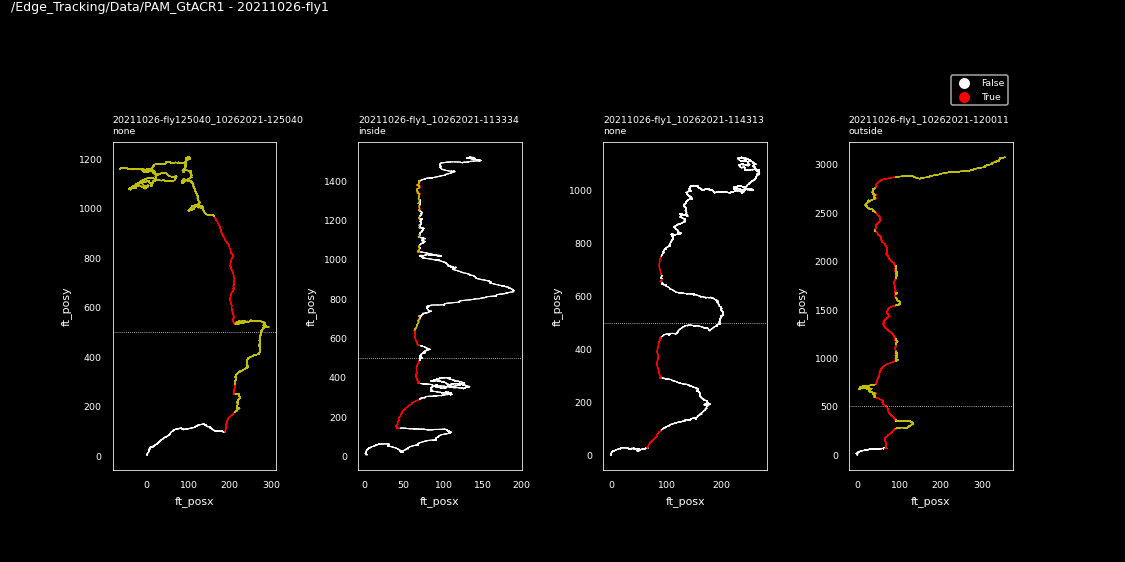

/tmp/ipykernel_59924/715071461.py:23: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=tdf_[tdf_['led1_stpt']==0], x="ft_posx", y="ft_posy", hue='led1_stpt', ax=ax,


<IPython.core.display.Javascript object>


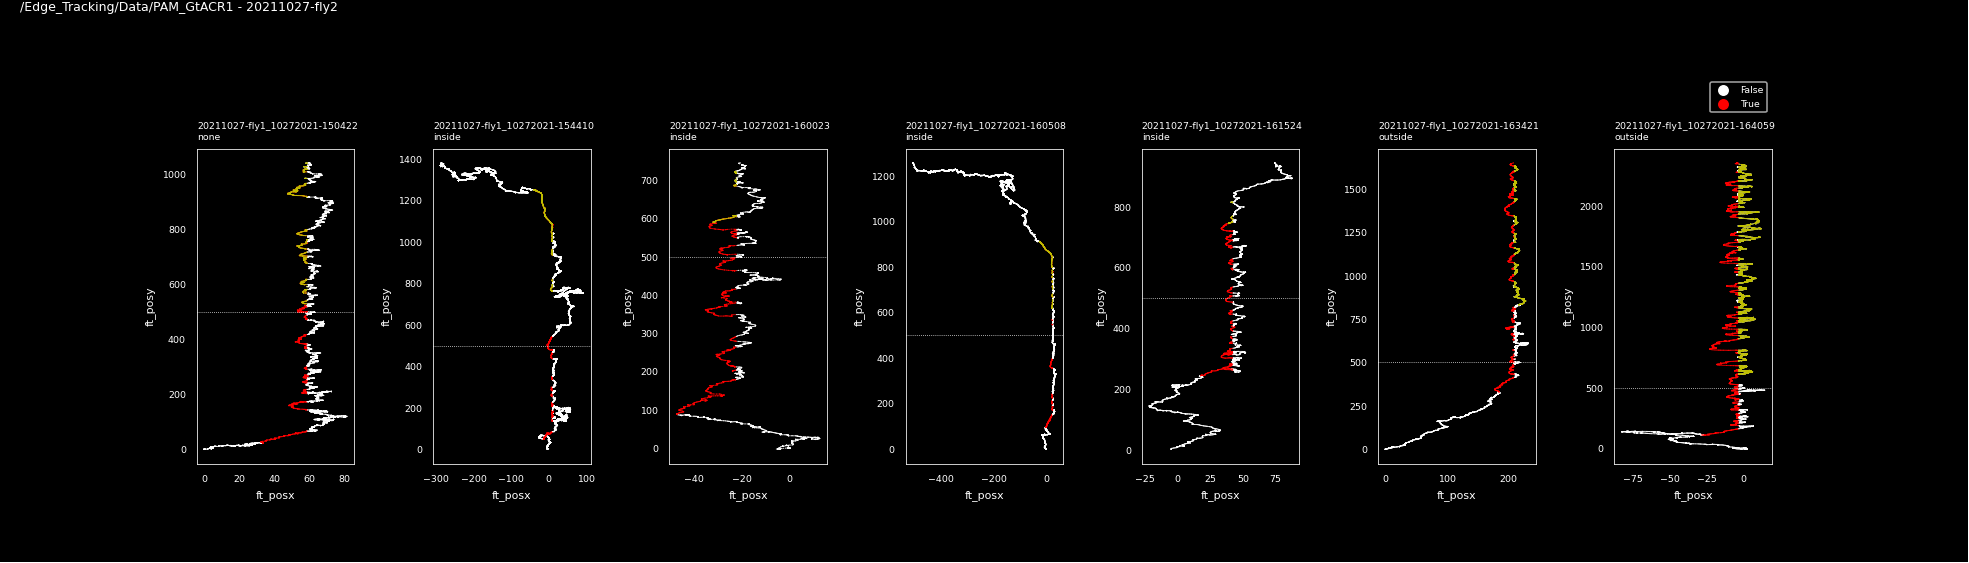

<IPython.core.display.Javascript object>


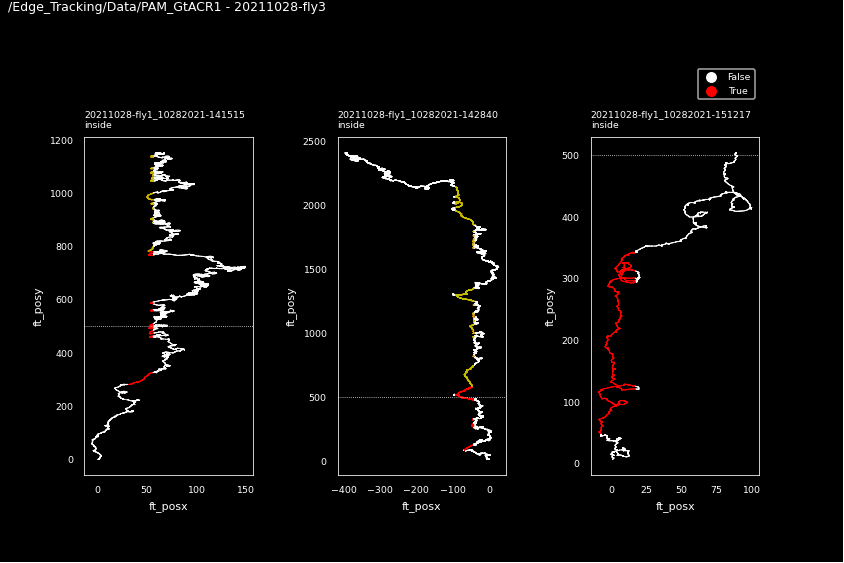

/tmp/ipykernel_59924/715071461.py:23: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=tdf_[tdf_['led1_stpt']==0], x="ft_posx", y="ft_posy", hue='led1_stpt', ax=ax,


<IPython.core.display.Javascript object>


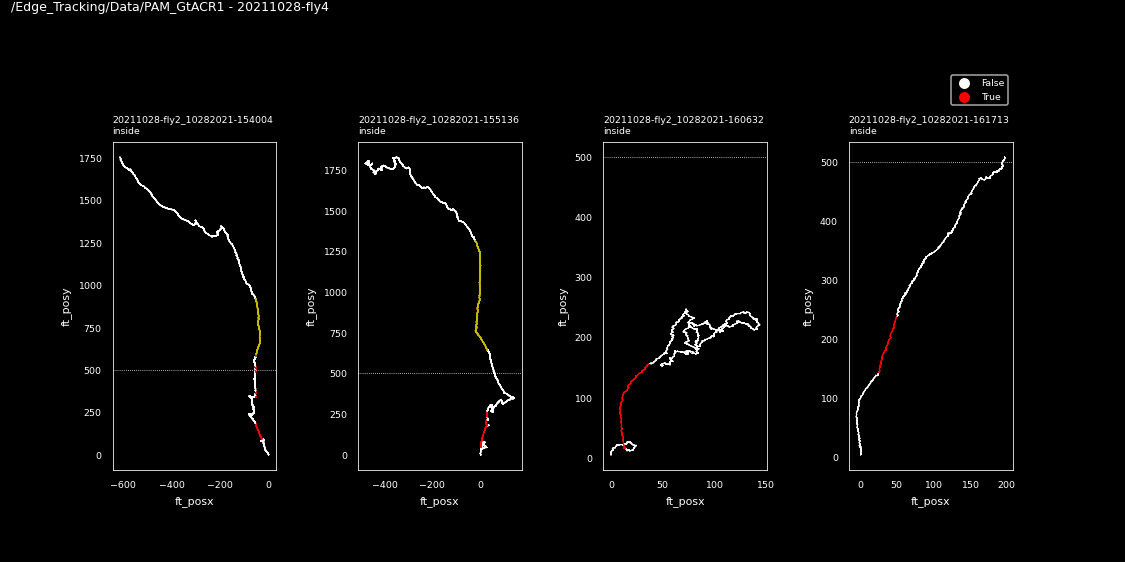

/tmp/ipykernel_59924/715071461.py:23: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=tdf_[tdf_['led1_stpt']==0], x="ft_posx", y="ft_posy", hue='led1_stpt', ax=ax,
/tmp/ipykernel_59924/715071461.py:23: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=tdf_[tdf_['led1_stpt']==0], x="ft_posx", y="ft_posy", hue='led1_stpt', ax=ax,


<IPython.core.display.Javascript object>


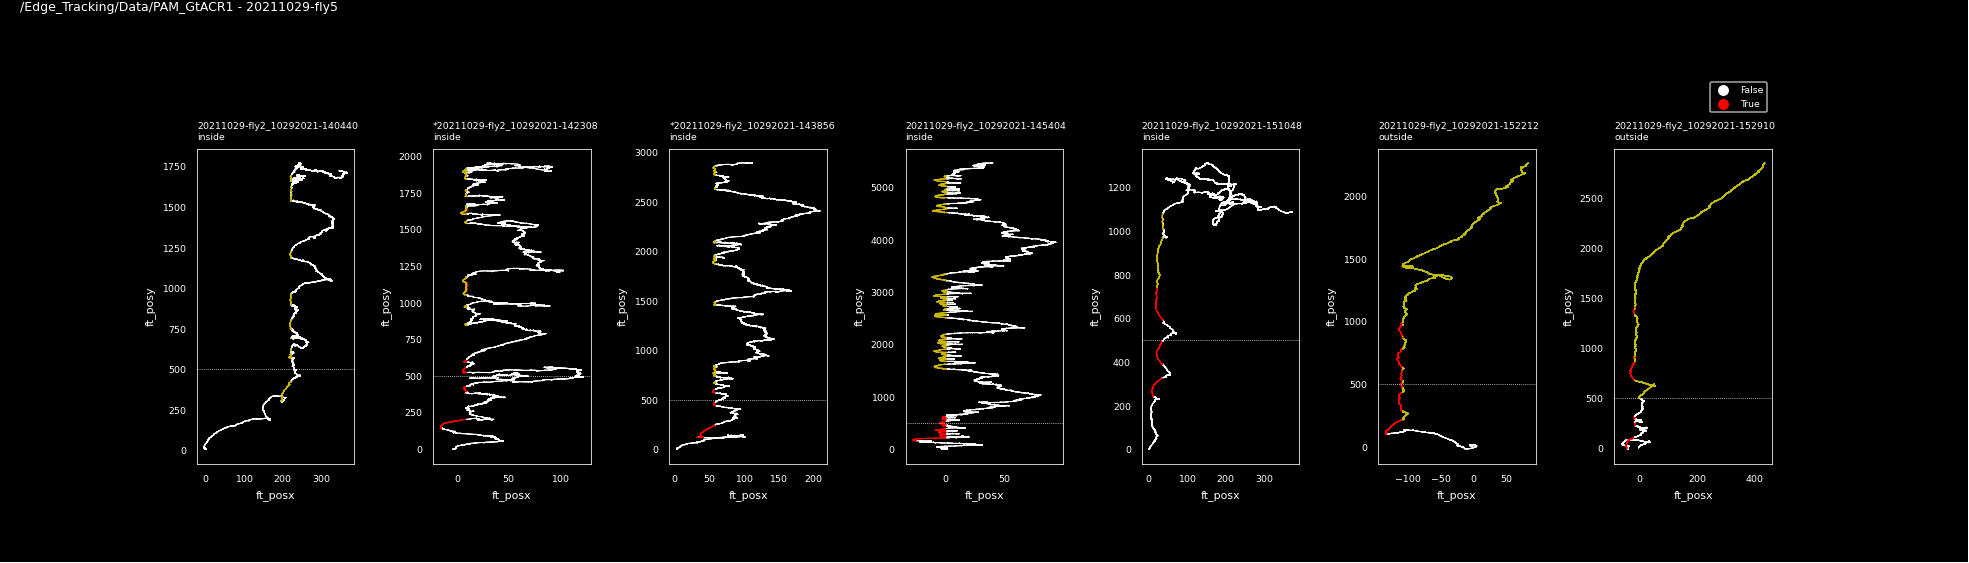

<IPython.core.display.Javascript object>


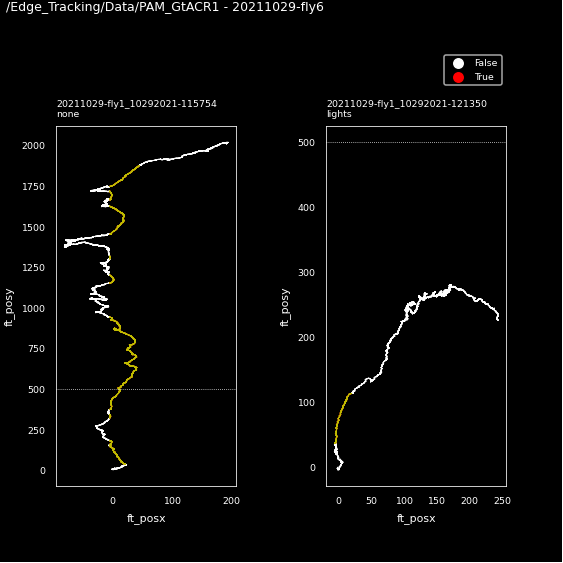

<IPython.core.display.Javascript object>


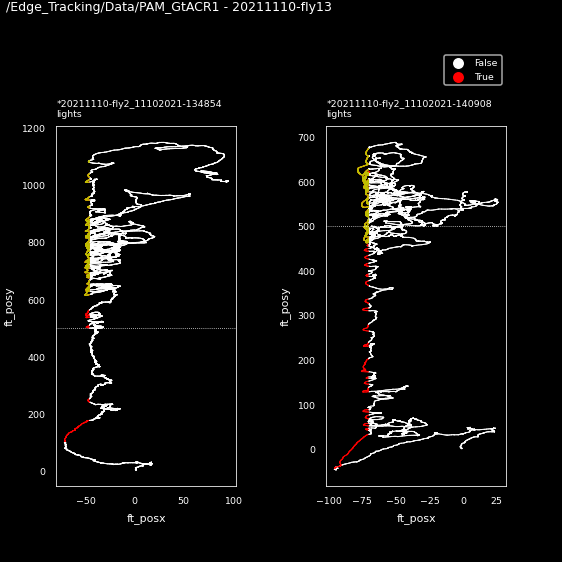

<IPython.core.display.Javascript object>


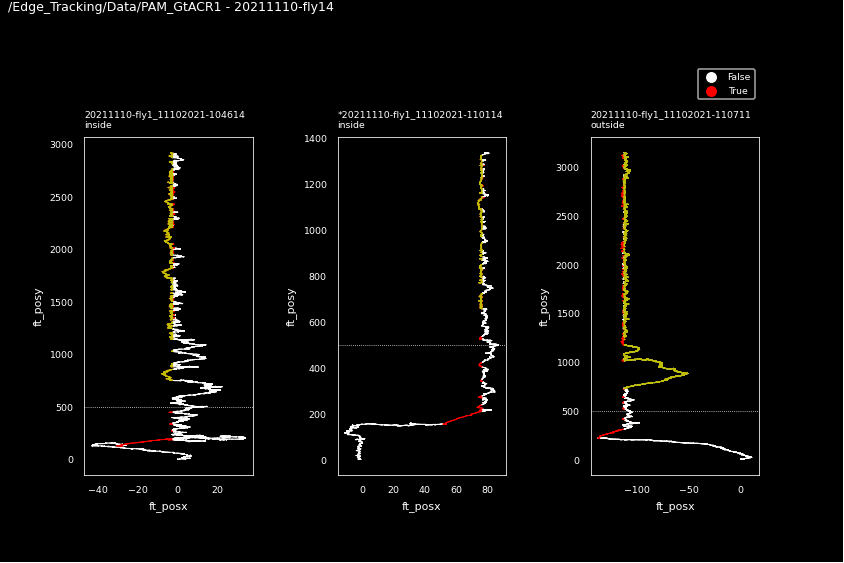

<IPython.core.display.Javascript object>


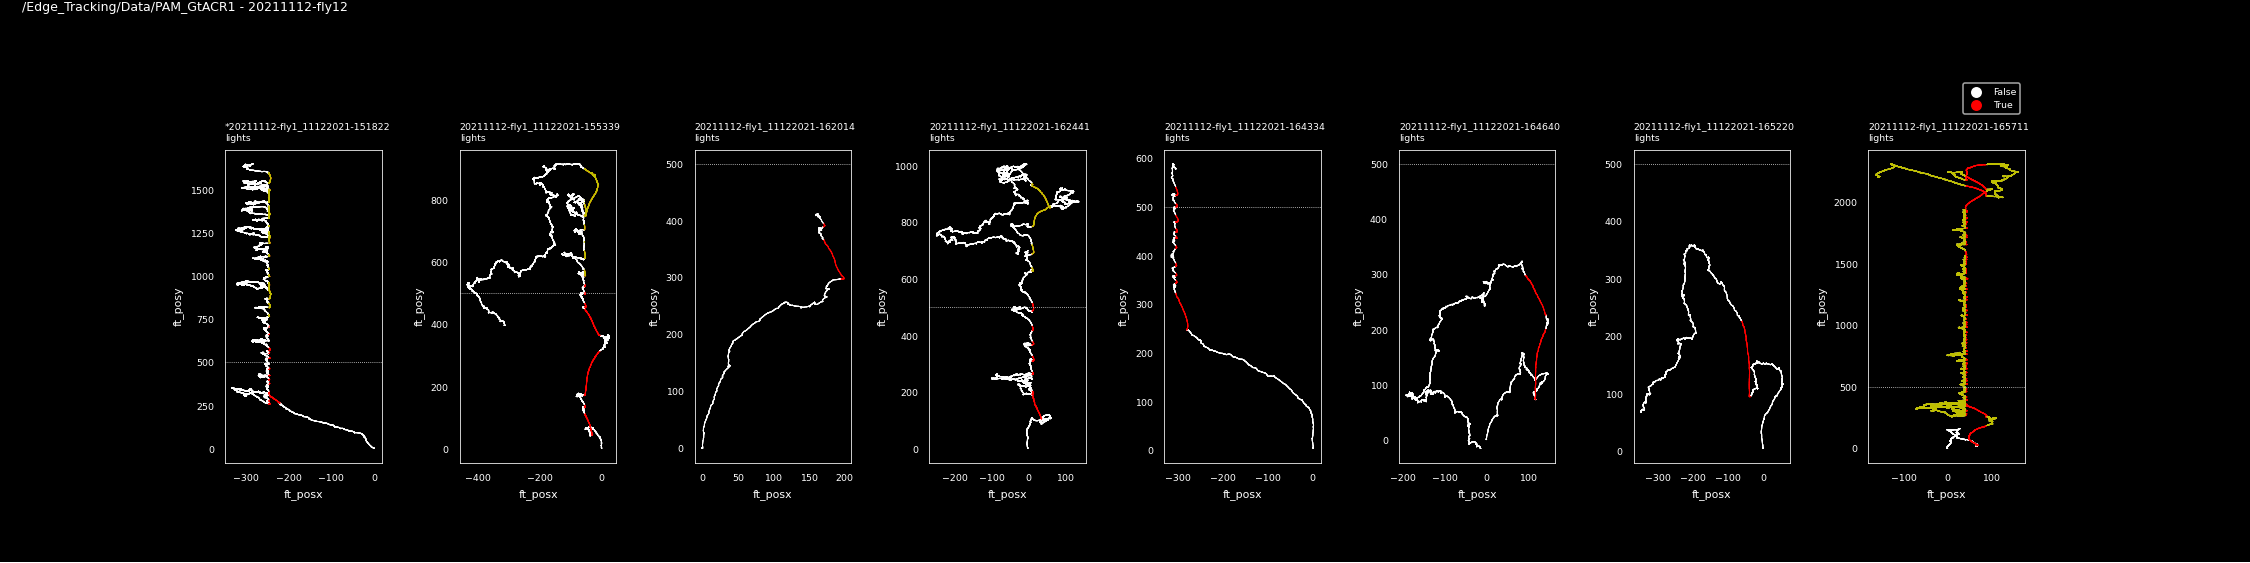

/tmp/ipykernel_59924/715071461.py:23: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=tdf_[tdf_['led1_stpt']==0], x="ft_posx", y="ft_posy", hue='led1_stpt', ax=ax,
/tmp/ipykernel_59924/715071461.py:23: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=tdf_[tdf_['led1_stpt']==0], x="ft_posx", y="ft_posy", hue='led1_stpt', ax=ax,
/tmp/ipykernel_59924/715071461.py:23: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=tdf_[tdf_['led1_stpt']==0], x="ft_posx", y="ft_posy", hue='led1_stpt', ax=ax,
/tmp/ipykernel_59924/715071461.py:23: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=tdf_[tdf_['led1_stpt']==0], x="ft_posx", y="ft_posy", hue='led1_stpt', ax=ax,


<IPython.core.display.Javascript object>


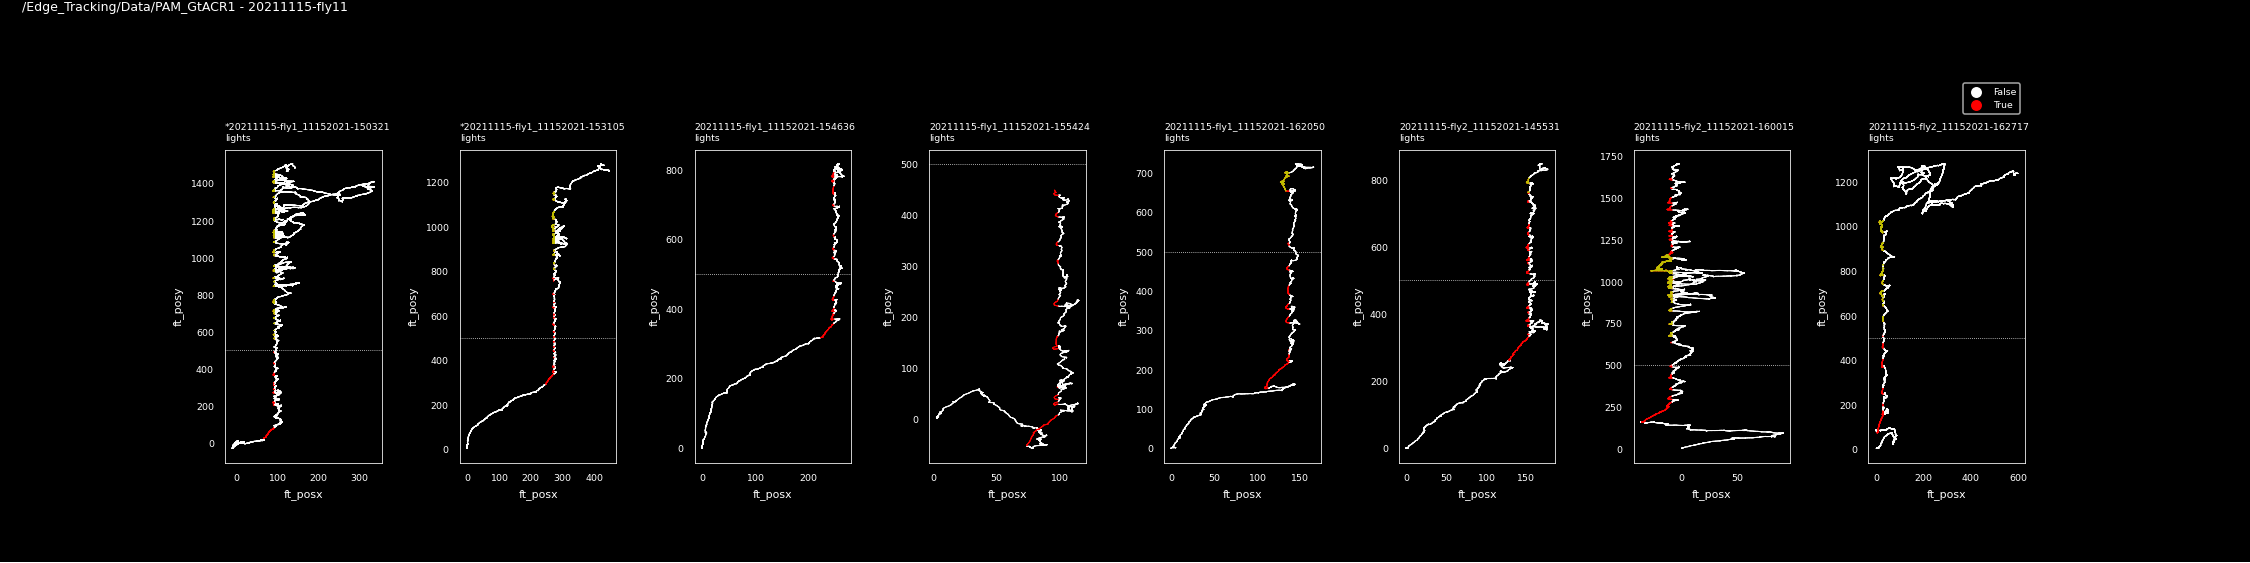

/tmp/ipykernel_59924/715071461.py:23: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=tdf_[tdf_['led1_stpt']==0], x="ft_posx", y="ft_posy", hue='led1_stpt', ax=ax,
/tmp/ipykernel_59924/715071461.py:23: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=tdf_[tdf_['led1_stpt']==0], x="ft_posx", y="ft_posy", hue='led1_stpt', ax=ax,


<IPython.core.display.Javascript object>


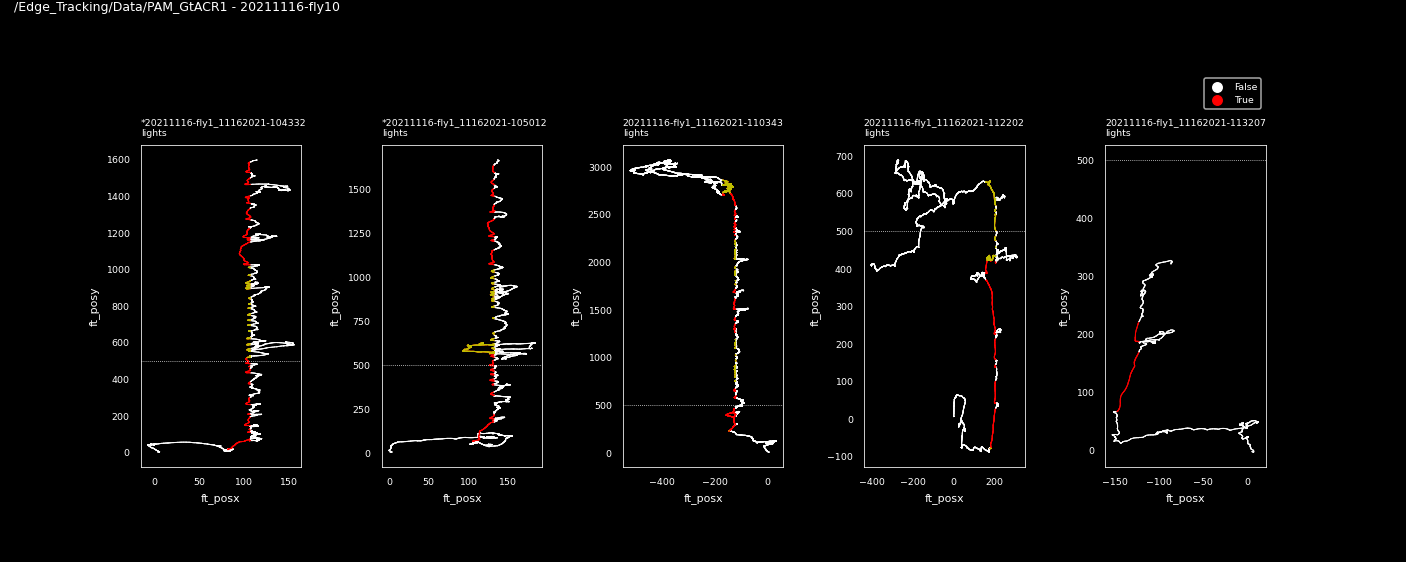

/tmp/ipykernel_59924/715071461.py:23: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=tdf_[tdf_['led1_stpt']==0], x="ft_posx", y="ft_posy", hue='led1_stpt', ax=ax,


<IPython.core.display.Javascript object>


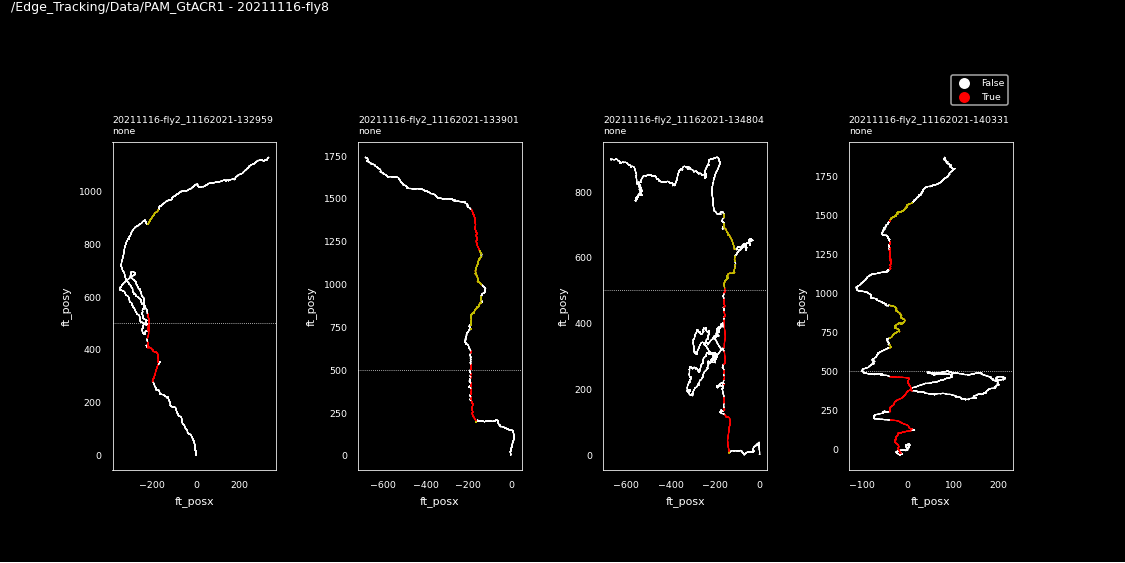

<IPython.core.display.Javascript object>


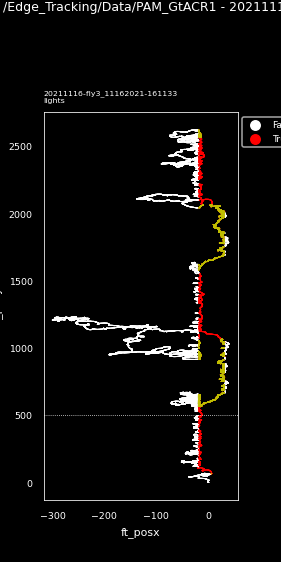

<IPython.core.display.Javascript object>


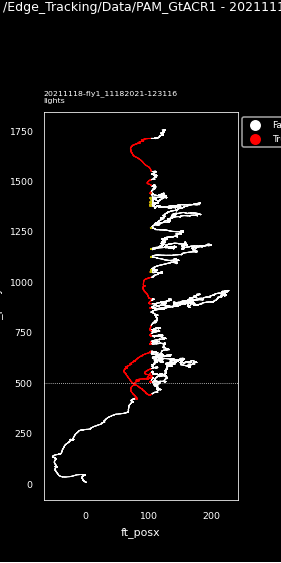

In [71]:

for fly_id, df_ in df.groupby('fly_id'):
    ntrials = len(df_['trial_id'].unique())
    fig, axn = pl.subplots(1, ntrials, figsize=(ntrials*2.5, 5))
    if len(df_['trial_id'].unique())==1:
        sns.scatterplot(data=df_, x="ft_posx", y="ft_posy", hue='instrip', ax=axn,
                        s=.5, edgecolor='none', palette=instrip_palette)
        sns.scatterplot(data=df_[df_['led1_stpt']==0], x="ft_posx", y="ft_posy", hue='led1_stpt', ax=axn,
                    s=.5, edgecolor='none', palette={0: 'y'}, legend=False)
        axn.set_box_aspect(2)
        axn.axhline(y=500, linestyle=':', c='w', linewidth=0.5)
        if df_['filename'].unique()[0] in incl_logs:
            trial_id = '*{}'.format(df_['trial_id'].unique()[0])
        else:
            trial_id = df_['trial_id'].unique()[0]
        currcond = df_['condition'].unique()[0]
        plot_title = "{}{}{}".format(trial_id, '\n', currcond)
        axn.set_title(plot_title, fontsize=5, loc='left')
        axn.legend(bbox_to_anchor=(1,1), loc='upper left')
    else:
        for ai, (ax, (trial_id, tdf_)) in enumerate(zip(axn.flat, df_.groupby('trial_id'))):
            sns.scatterplot(data=tdf_, x="ft_posx", y="ft_posy", hue='instrip', ax=ax,
                            s=.5, edgecolor='none', palette=instrip_palette)
            sns.scatterplot(data=tdf_[tdf_['led1_stpt']==0], x="ft_posx", y="ft_posy", hue='led1_stpt', ax=ax,
                    s=.5, edgecolor='none', palette={0: 'y'}, legend=False)
            ax.set_box_aspect(2)
            ax.axhline(y=500, linestyle=':', c='w', linewidth=0.5)
            if tdf_['filename'].unique()[0] in incl_logs:
                trial_id = '*{}'.format(tdf_['trial_id'].unique()[0])
            else:
                trial_id = tdf_['trial_id'].unique()[0]
            currcond = tdf_['condition'].unique()[0]
            plot_title = "{}{}{}".format(trial_id, '\n', currcond)
            ax.set_title(plot_title, fontsize=6, loc='left')
            if ai == (ntrials-1):
                ax.legend(bbox_to_anchor=(1,1.1), loc='lower right')
            else:
                ax.legend_.remove()
    pl.subplots_adjust(left=0.1, right=0.9, wspace=0.5, top=0.8)
    util.label_figure(fig, '{} - {}'.format(fig_id, fly_id))
    pl.savefig(os.path.join(curr_figdir, '{}.png'.format(fly_id)))

# INSIDE ACTIVATION

In [31]:
# exclude weird/unknown conditions:

exclude = [
    '10262021-125040_PAMGtACR1_no_lights_strip', 
    '10262021-120011_PAMGtACR1_lights_outside_Fly1_003',
    '11162021-161133_PAMGtACR1_Fly3_006', 
    '11122021-165711_PAMGtACR1_Fly1_008'
]

df = df0_all[(df0_all['condition'].isin(['inside', 'lights'])) & (~df0_all['filename'].isin(exclude))].copy()
df = df.reset_index(drop=True)


In [23]:
'20211116-fly8' in df0_all['fly_id'].unique()

True

In [18]:
trial_counts = df[['fly_id', 'filename']].drop_duplicates().groupby('fly_id').count()

nr = len(df['fly_id'].unique())
nc = int(trial_counts.max())
print(nr, nc)

12 8


In [20]:
importlib.reload(putil)
curr_figdir = os.path.join(figdir, 'inside_lights')

/home/julianarhee/edgetracking-googledrive/Edge_Tracking/Data/jyr/PAM_GtACR1/figures/inside_lights


<IPython.core.display.Javascript object>


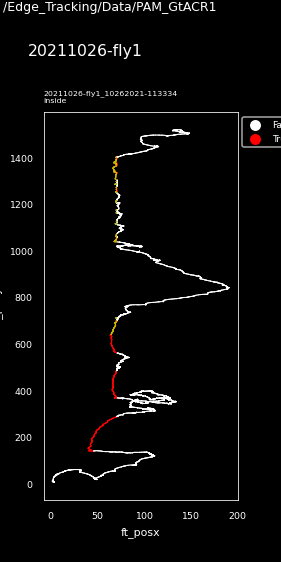

<IPython.core.display.Javascript object>


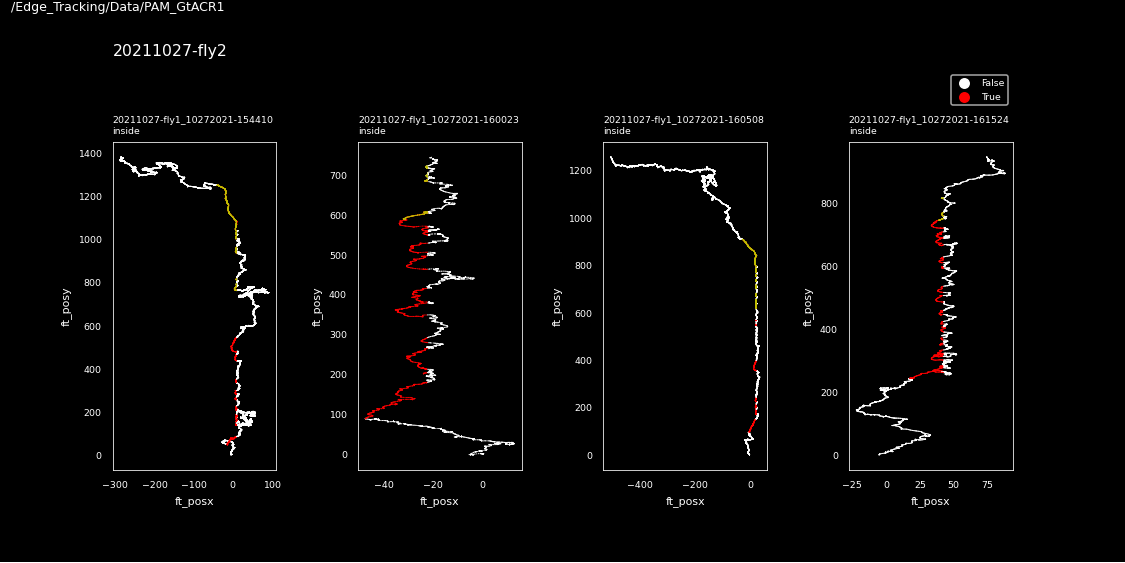

<IPython.core.display.Javascript object>


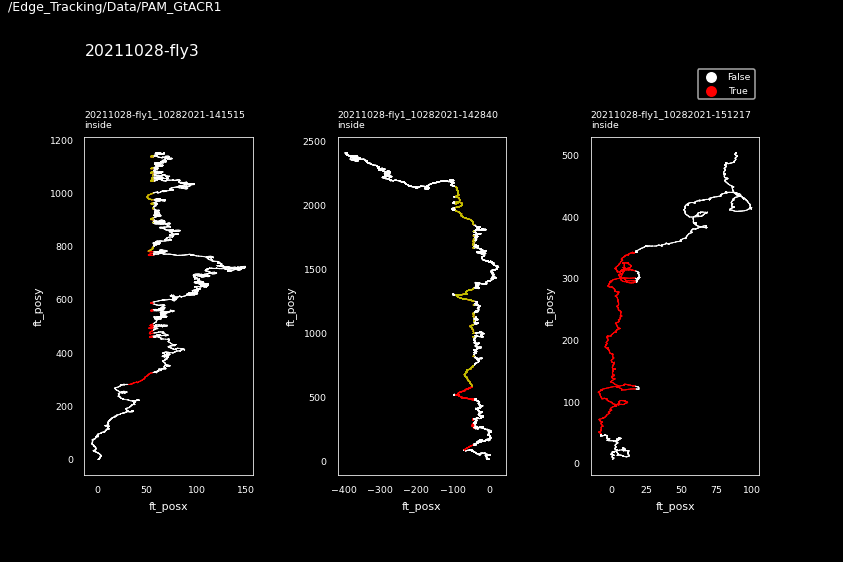

/home/julianarhee/Repositories/plume-tracking/plotting.py:173: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=tdf_[tdf_['led1_stpt']==0],


<IPython.core.display.Javascript object>


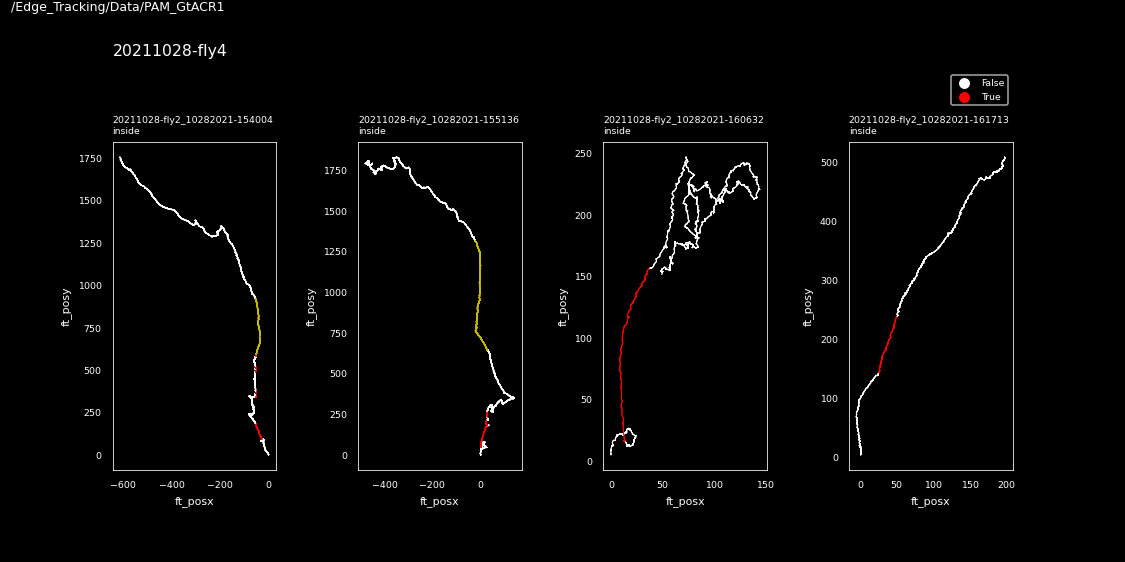

/home/julianarhee/Repositories/plume-tracking/plotting.py:173: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=tdf_[tdf_['led1_stpt']==0],
/home/julianarhee/Repositories/plume-tracking/plotting.py:173: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=tdf_[tdf_['led1_stpt']==0],


<IPython.core.display.Javascript object>


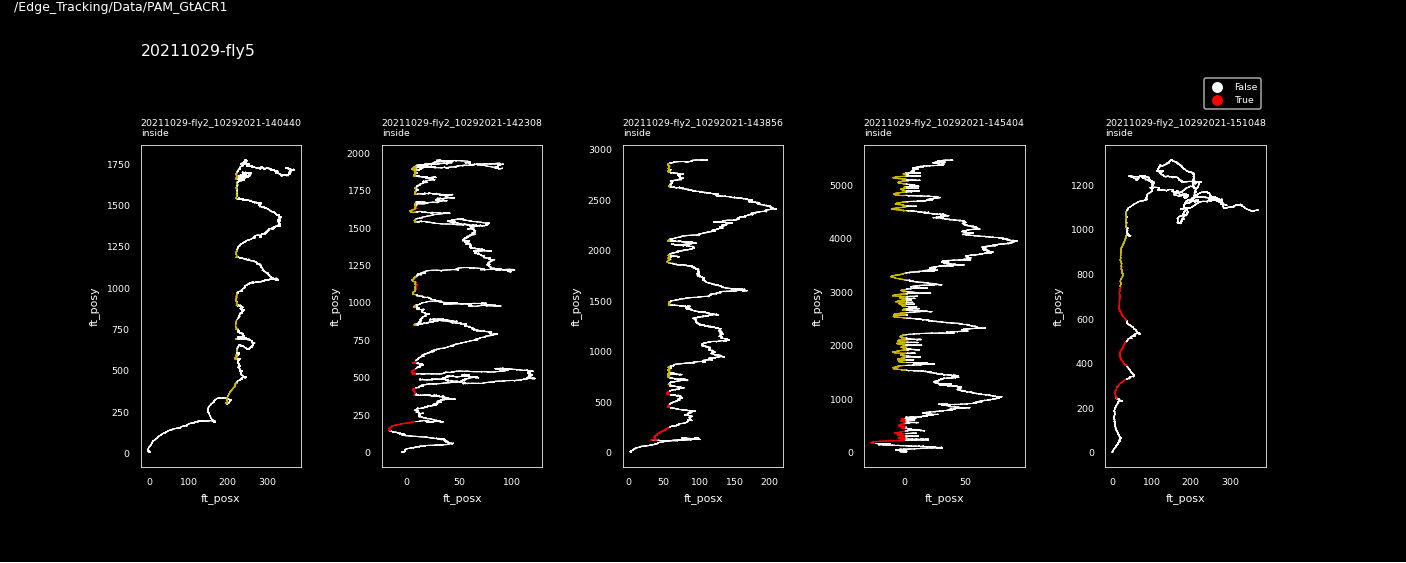

<IPython.core.display.Javascript object>


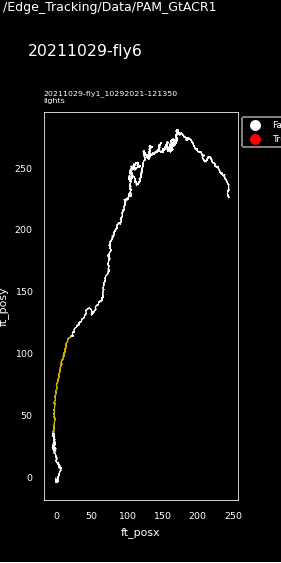

<IPython.core.display.Javascript object>


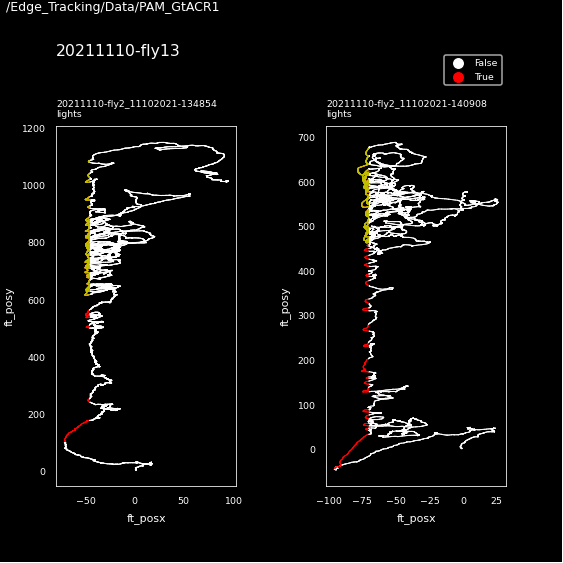

<IPython.core.display.Javascript object>


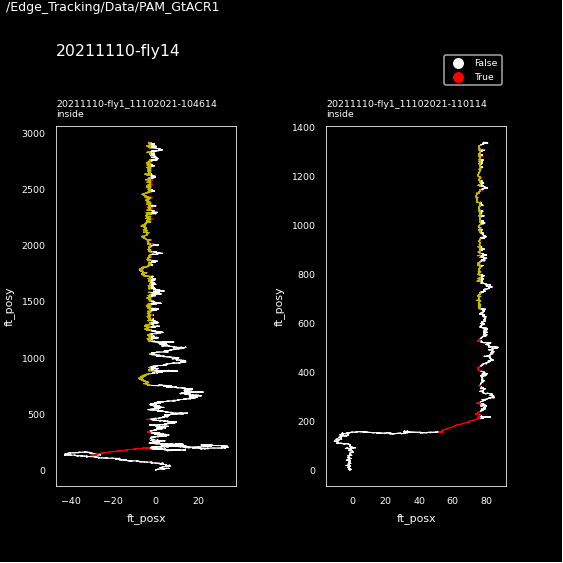

<IPython.core.display.Javascript object>


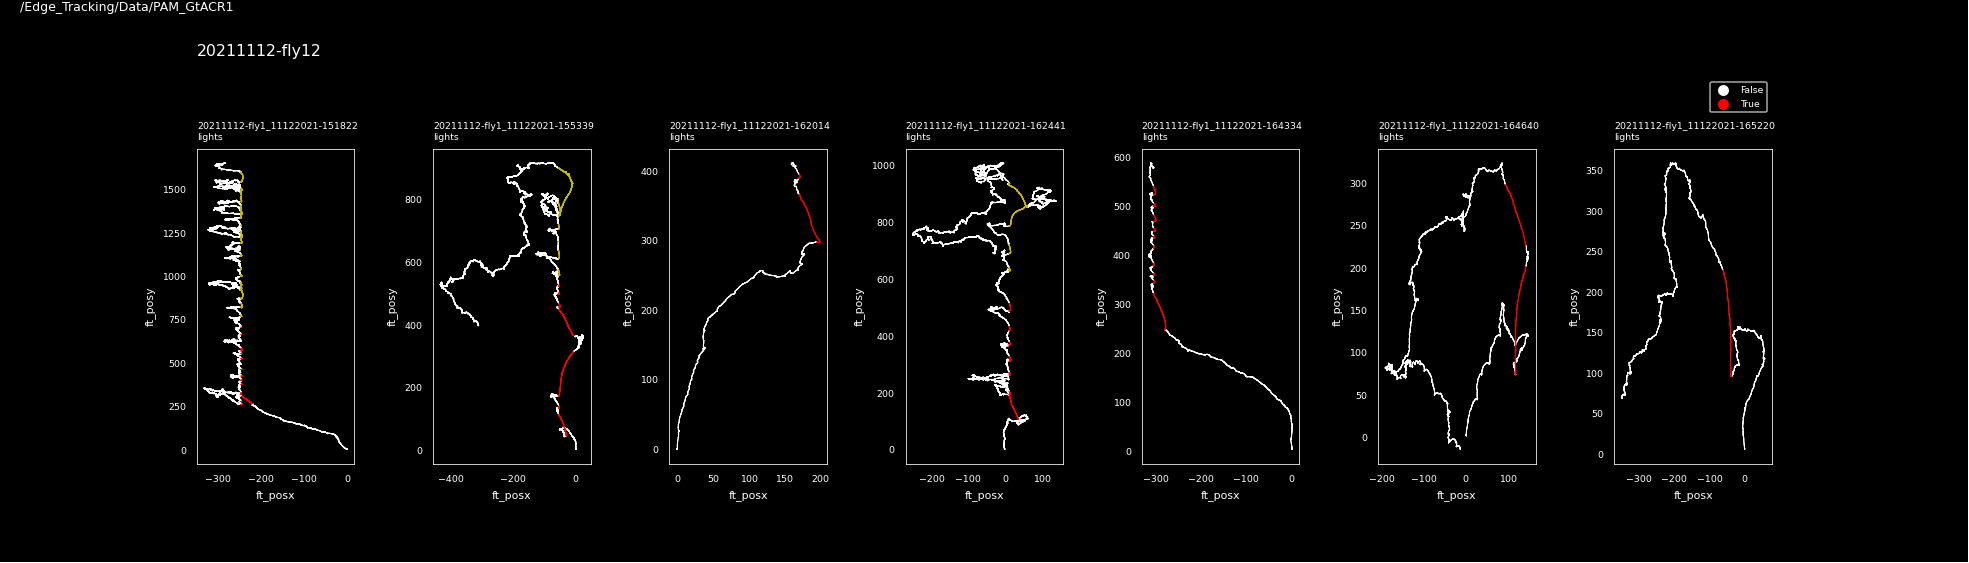

/home/julianarhee/Repositories/plume-tracking/plotting.py:173: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=tdf_[tdf_['led1_stpt']==0],
/home/julianarhee/Repositories/plume-tracking/plotting.py:173: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=tdf_[tdf_['led1_stpt']==0],
/home/julianarhee/Repositories/plume-tracking/plotting.py:173: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=tdf_[tdf_['led1_stpt']==0],
/home/julianarhee/Repositories/plume-tracking/plotting.py:173: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=tdf_[tdf_['led1_stpt']==0],


<IPython.core.display.Javascript object>


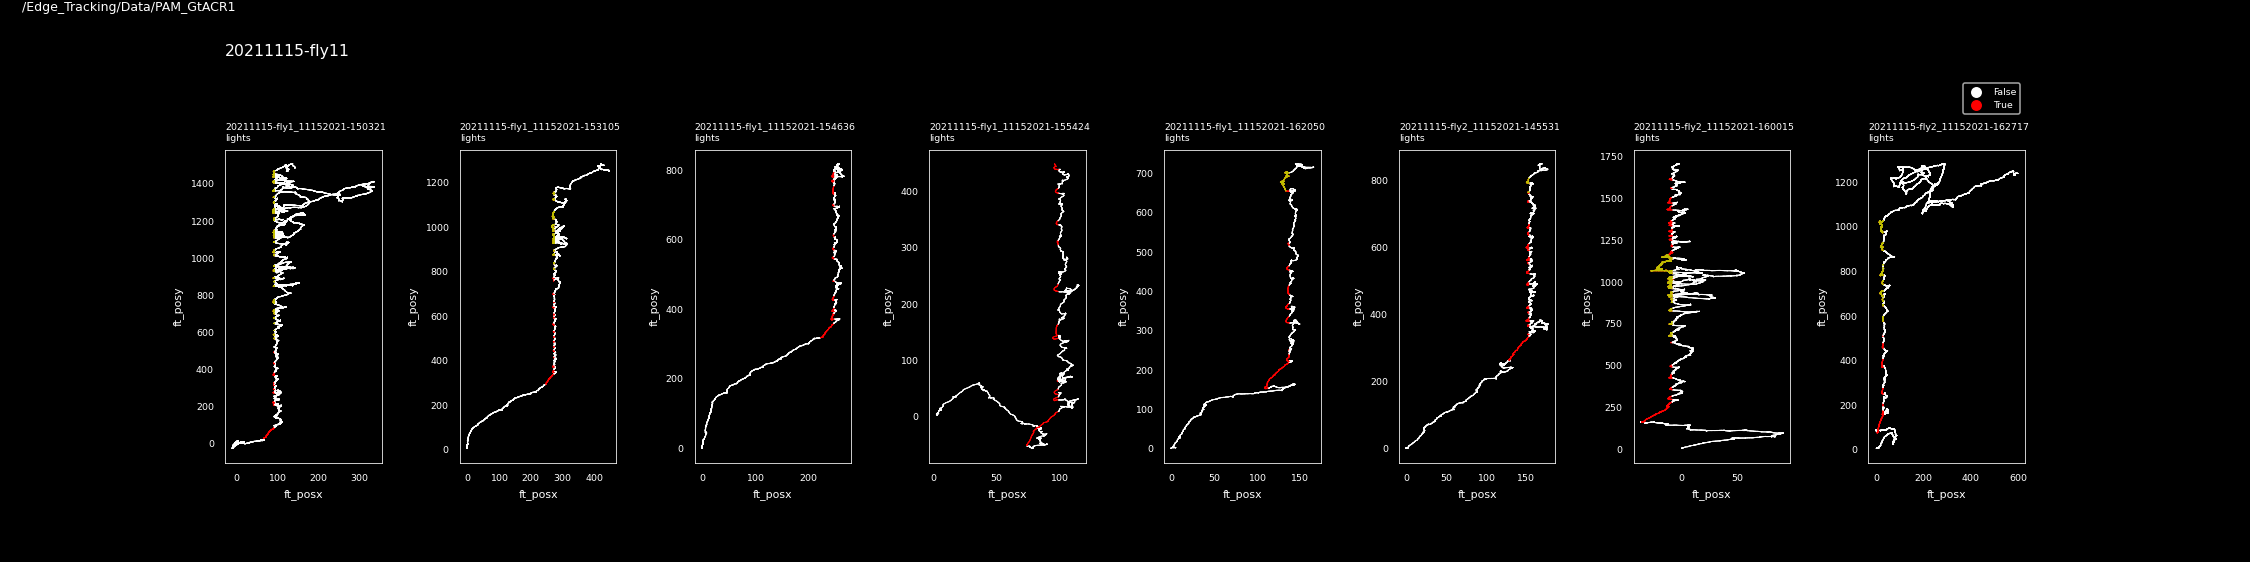

/home/julianarhee/Repositories/plume-tracking/plotting.py:173: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=tdf_[tdf_['led1_stpt']==0],
/home/julianarhee/Repositories/plume-tracking/plotting.py:173: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=tdf_[tdf_['led1_stpt']==0],


<IPython.core.display.Javascript object>


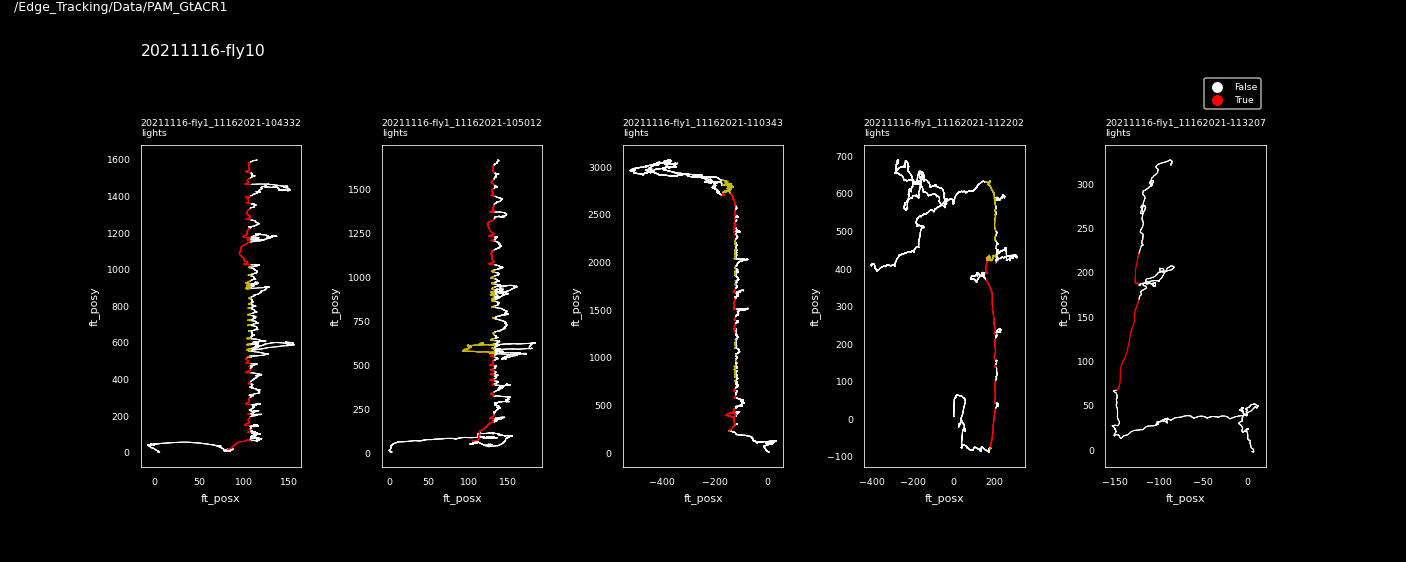

/home/julianarhee/Repositories/plume-tracking/plotting.py:173: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=tdf_[tdf_['led1_stpt']==0],


<IPython.core.display.Javascript object>


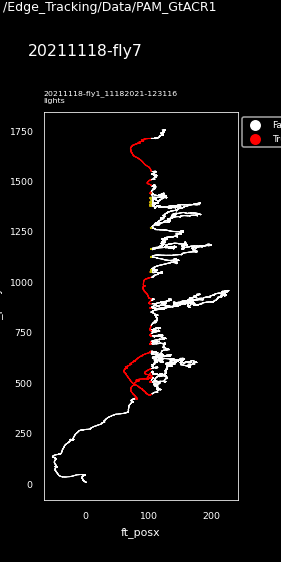

In [21]:
print(curr_figdir)
for ri, (fly_id, flydf) in enumerate(df.groupby('fly_id')):
    fig = putil.plot_one_flys_trials(flydf)
    pl.subplots_adjust(left=0.1, right=0.9, wspace=0.5, top=0.8)
    util.label_figure(fig, fig_id)
    fig.text(0.1, 0.9, fly_id) #'{} - {}'.format(fig_id, fly_id))
    
    pl.savefig(os.path.join(curr_figdir, '{}.png'.format(fly_id)))

In [41]:
fly_ids = df['fly_id'].unique()
fly_ids

array(['20211026-fly1', '20211027-fly2', '20211028-fly3', '20211028-fly4',
       '20211029-fly6', '20211029-fly5', '20211110-fly14',
       '20211110-fly13', '20211112-fly12', '20211115-fly11',
       '20211116-fly10', '20211118-fly7'], dtype=object)

# find ETs

In [517]:
import trajectory as traj


In [518]:
curr_figdir = os.path.join(savedir, 'ets')
if not os.path.exists(curr_figdir):
    os.makedirs(curr_figdir)

In [519]:
strip_width=50
strip_sep=1000
#min_global_upwind_dist = 300
max_crossovers = 0
max_instrip_upwind_percent=0.4
min_outside_bouts=5


et_flies={}
for fly_id, flydf in df.groupby('fly_id'):
    ets = []
    for trial_id, tmpdf in flydf.groupby('filename'):
        if tmpdf[tmpdf['led_on']].shape[0]==0:
            continue
        led_ix = tmpdf[tmpdf['led_on']].iloc[0].name
        currdf = tmpdf.loc[0:led_ix].copy()
        odor_bounds = butil.find_strip_borders(currdf, 
                                            entry_ix=currdf[currdf['instrip']].iloc[0].name,
                                            strip_width=strip_width, strip_sep=strip_sep)
        et_bouts, et_boutstats, et_passkey = traj.find_et_bouts(currdf,
                                        odor_bounds, strip_width=strip_width, strip_sep=strip_sep, 
                                       max_instrip_upwind_percent=max_instrip_upwind_percent, 
                                       max_crossovers=max_crossovers, 
                                        min_outside_bouts=min_outside_bouts)
        if len(et_bouts)>0:
            ets.append(trial_id)
    if len(ets)>0:
        et_flies.update({fly_id: ets})
    

not et: 0
Is ET: 0 True
Is ET: 0 True
Is ET: 0 True
Is ET: 0 True
Is ET: 0 True
not et: 0
not et: 0
not et: 0
not et: 0
not et: 0
not et: 0
Is ET: 0 True
not et: 0
not et: 0
not et: 0
Is ET: 0 True
not et: 0
Is ET: 0 True
Is ET: 0 True
not et: 0
Is ET: 0 True
Is ET: 0 True
Is ET: 0 True
Is ET: 0 True
Is ET: 0 True
Is ET: 0 True
Is ET: 0 True
Is ET: 0 True
Is ET: 0 True
not et: 0
not et: 0
Is ET: 0 True


In [520]:
incl_files = util.flatten(et_flies.values())
incl_files

['10272021-154410_PAMGTACR1_thresh_lights_Fly1_003',
 '10272021-160023_PAMGtACR1_thresh_lights_LT_early_Fly1_004',
 '10272021-160508_PAMGTACR1_thresh_lights_on_Fly1_005',
 '10272021-161524_PAM_GTACR1_thresh_lights_on_Fly1_007',
 '10282021-141515_PAMGTACR1_thresh_lights_on_LT_Fly1_001',
 '10292021-145404_PAMGTACR1_lights_off_Fly2_004',
 '11102021-140908_PAMGtACR1_thresh_lights_old_food_yeast_Fly2_002',
 '11102021-110114_PAMGTACR1_thresh_lights_old_food_yeast_Fly1_002',
 '11122021-151822_PAMGtACR1_Fly1_001',
 '11122021-162441_PAMGtACR1_Fly1_004',
 '11152021-145531_PAMGtACR1_Fly2_001',
 '11152021-150321_PAMGtACR1_Fly1_002',
 '11152021-153105_PAMGtACR1_Fly1_003',
 '11152021-160015_PAMGTACR1_Fly2_006',
 '11152021-162050_PAMGTACR1_Fly1_007',
 '11152021-162717_PAMGtACR1_Fly2_008',
 '11162021-104332_PAMGTACR1_Fly1_001',
 '11162021-105012_PAMGtACR1_Fly1_002',
 '11182021-123116_PAMGtACR1_Fly1_001']

In [521]:
len(incl_files)

19

In [522]:
len(et_flies.keys())

9

In [523]:
etdf = df[df['filename'].isin(incl_files)].copy().reset_index(drop=True)
etdf = butil.correct_manual_conditions(etdf, logdf=logdf, verbose=True)
etdf['led_on'] = etdf['led1_stpt'] == 0

Correcting experiment conditions: None
... updated fly name: 2
... updated fly name: 2
... updated fly name: 2
... updated fly name: 2
... updated fly name: 3
... updated fly name: 5
... updated fly name: 14
... updated fly name: 13
... updated fly name: 12
... updated fly name: 12
... updated fly name: 11
... updated fly name: 11
... updated fly name: 11
... updated fly name: 11
... updated fly name: 11
... updated fly name: 11
... updated fly name: 10
... updated fly name: 10
... updated fly name: 7


In [484]:
importlib.reload(putil)

<module 'plotting' from '/home/julianarhee/Repositories/plume-tracking/plotting.py'>

<IPython.core.display.Javascript object>


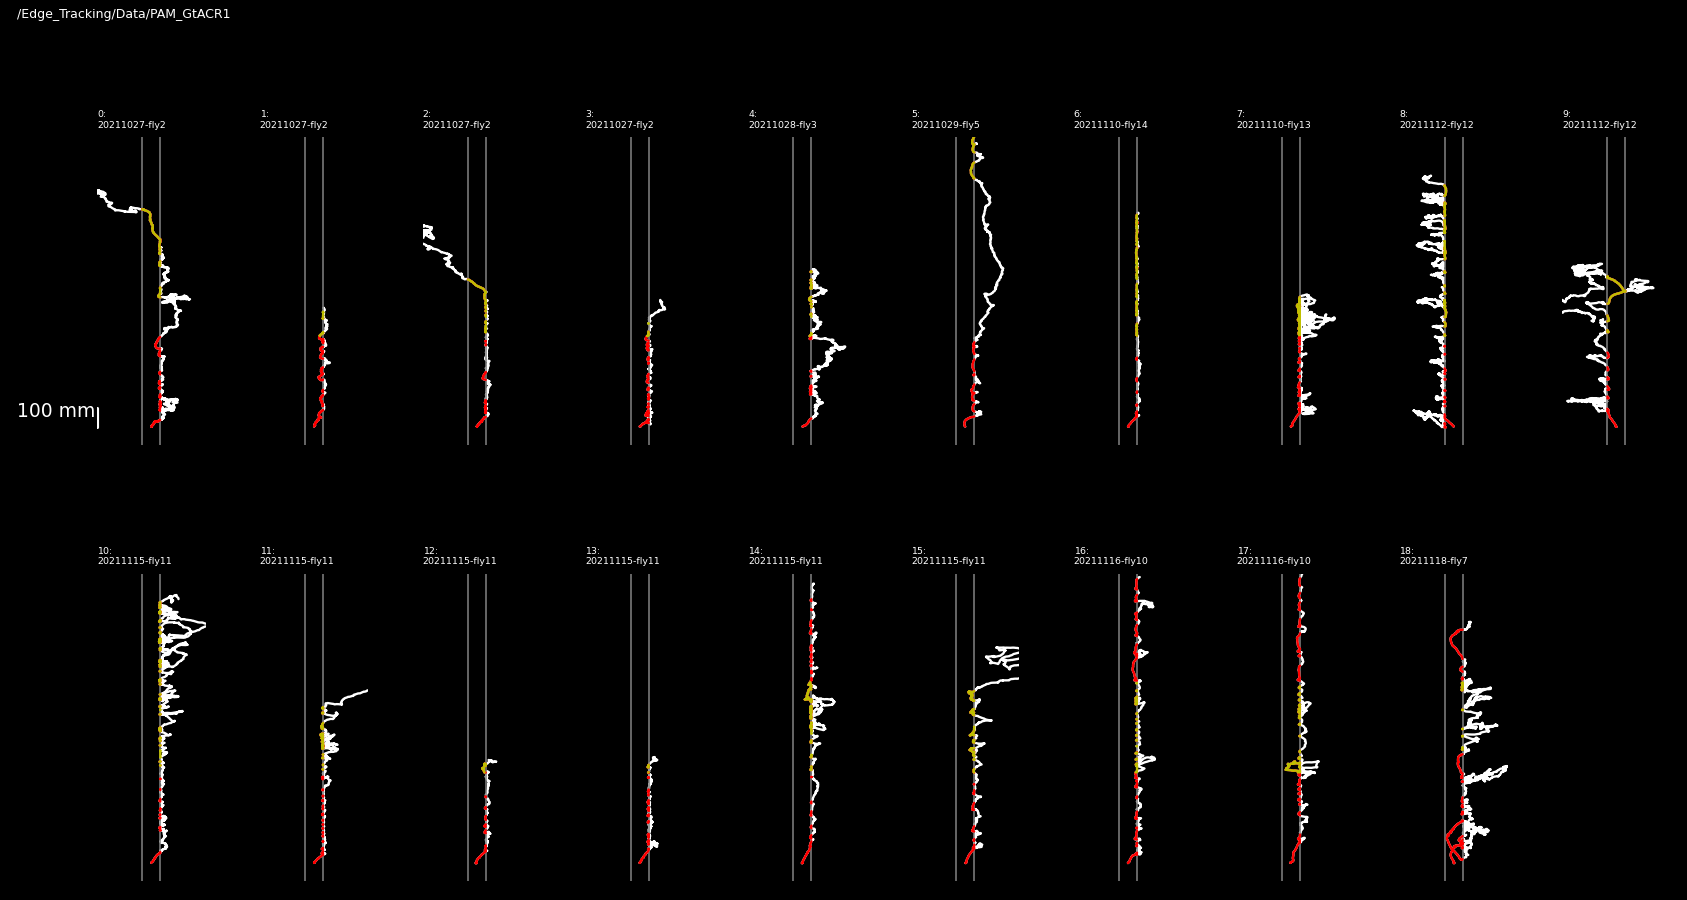

In [524]:
nr=2
nc = 10
bool_colors=['r', 'y']
bool_vars = ['instrip', 'led_on']
fig = putil.plot_array_of_trajectories(etdf, nr=nr, nc=nc, bool_colors=bool_colors, bool_vars=bool_vars, title='fly_id')

util.label_figure(fig, fig_id)
pl.savefig(os.path.join(curr_figdir, 'trajectories.png'))

In [525]:
et_flies

{'20211027-fly2': ['10272021-154410_PAMGTACR1_thresh_lights_Fly1_003',
  '10272021-160023_PAMGtACR1_thresh_lights_LT_early_Fly1_004',
  '10272021-160508_PAMGTACR1_thresh_lights_on_Fly1_005',
  '10272021-161524_PAM_GTACR1_thresh_lights_on_Fly1_007'],
 '20211028-fly3': ['10282021-141515_PAMGTACR1_thresh_lights_on_LT_Fly1_001'],
 '20211029-fly5': ['10292021-145404_PAMGTACR1_lights_off_Fly2_004'],
 '20211110-fly13': ['11102021-140908_PAMGtACR1_thresh_lights_old_food_yeast_Fly2_002'],
 '20211110-fly14': ['11102021-110114_PAMGTACR1_thresh_lights_old_food_yeast_Fly1_002'],
 '20211112-fly12': ['11122021-151822_PAMGtACR1_Fly1_001',
  '11122021-162441_PAMGtACR1_Fly1_004'],
 '20211115-fly11': ['11152021-145531_PAMGtACR1_Fly2_001',
  '11152021-150321_PAMGtACR1_Fly1_002',
  '11152021-153105_PAMGtACR1_Fly1_003',
  '11152021-160015_PAMGTACR1_Fly2_006',
  '11152021-162050_PAMGTACR1_Fly1_007',
  '11152021-162717_PAMGtACR1_Fly2_008'],
 '20211116-fly10': ['11162021-104332_PAMGTACR1_Fly1_001',
  '11162021

# Compare PRE vs POST activation

In [846]:
# pre_list = []
# post_list = []
for fn, df_ in etdf.groupby('filename'):
    led_ix = df_[df_['led_on']].iloc[0].name
    first_led_bout = df_.loc[led_ix]['boutnum']
    
    etdf.loc[(etdf['filename']==fn) & (etdf['boutnum']<first_led_bout), 'epoch'] = 'pre'
    etdf.loc[(etdf['filename']==fn) & (etdf['boutnum']>=first_led_bout), 'epoch'] = 'post'
etdf['led_on'] = etdf['led1_stpt']==0
etdf['led_on'].unique()
etdf['bout_type'] = ['instrip' if i==1 else 'outstrip' for i in etdf['instrip']]


In [847]:
e_list = []
multi_block = ['11152021-160015_PAMGTACR1_Fly2_006']
for fn, df_ in etdf.groupby('filename'):
    if fn in multi_block:
        last_bout = df_[df_['led_on']]['boutnum'].max()
        currdf = df_[df_['boutnum']<=last_bout]
    else:
        currdf = df_.copy()
    e_list.append(currdf)
etdf1 = pd.concat(e_list, axis=0)

# bout metrics

In [867]:
importlib.reload(butil)

<module 'behavior' from '/home/julianarhee/Repositories/plume-tracking/behavior.py'>

In [1253]:
# boutdf = pd.concat([df_.groupby(['boutnum', 'condition'], group_keys=True)\
#                  .apply(butil.get_bout_metrics).unstack().reset_index() \
#                  for (fi, fn), df_ in etdf.groupby(['fly_id', 'filename'])]).reset_index()
boutdf = butil.get_bout_metrics(etdf1) #etdf1)
boutdf.shape

/home/julianarhee/Repositories/plume-tracking/behavior.py:2763: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  boutdf = pd.concat(b_list, axis=0).reset_index(drop=True)


(934, 31)

## filter out 1st instrip and last outstrip

In [1254]:
boutdf_filt = traj.filter_first_instrip_last_outstrip(boutdf)
# --------------------------------------------------------
mean_boutdf = boutdf_filt.groupby(['filename', 'fly_name', 'instrip', 'condition', 'bout_type', 'epoch']).mean().reset_index()
# mean_boutdf['bout_type'] = ['instrip' if i==1 else 'outstrip' for i in mean_boutdf['instrip']]
mean_boutdf['instrip'] = mean_boutdf['instrip'].astype(bool)
mean_boutdf['led_on'] = mean_boutdf['led_on'].astype(bool)

mean_boutdf.shape
mean_boutdf.columns

(878, 31)


/tmp/ipykernel_519679/1455236351.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_boutdf = boutdf_filt.groupby(['filename', 'fly_name', 'instrip', 'condition', 'bout_type', 'epoch']).mean().reset_index()


Index(['filename', 'fly_name', 'instrip', 'condition', 'bout_type', 'epoch',
       'duration', 'upwind_dist_range', 'upwind_dist_firstlast',
       'crosswind_dist_range', 'crosswind_dist_firstlast', 'path_length',
       'path_length_x', 'path_length_y', 'rel_time', 'n_frames',
       'average_ft_heading', 'speed', 'upwind_speed', 'crosswind_speed',
       'date', 'odor_on', 'led_on', 'boutnum', 'sig_status'],
      dtype='object')

In [1255]:
epoch_counts = mean_boutdf.groupby('filename')['epoch'].count().reset_index()
excluded_files = epoch_counts[epoch_counts['epoch']!=4]['filename'].values
mean_boutdf = mean_boutdf[~mean_boutdf['filename'].isin(excluded_files)]

# Compare Pre and Post LED 

In [1256]:
import matplotlib.gridspec as gridspec
import stats as st
importlib.reload(putil)

<module 'plotting' from '/home/julianarhee/Repositories/plume-tracking/plotting.py'>

In [1257]:
curr_figdir = os.path.join(figdir, 'ets', 'by-individual')
if not os.path.exists(curr_figdir):
    os.makedirs(curr_figdir)
print(curr_figdir)

/home/julianarhee/edgetracking-googledrive/Edge_Tracking/Data/jyr/PAM_GtACR1/figures/ets/by-individual


In [1258]:
# select variables and colors to plot
yvarnames = ['duration',  'speed','path_length', 
            'path_length_x', 'path_length_y',
            'crosswind_speed', 'crosswind_dist_range', 
            'upwind_speed', 'upwind_dist_range']
instrip_palette2={'instrip': 'r', 'outstrip': 'cornflowerblue'}

In [1259]:
# Merge for easier plotting
meltdf = pd.melt(boutdf_filt, id_vars=['fly_id', 'filename', 'bout_type', 'epoch_type'],
               value_vars=yvarnames, value_name='value')
meltdf.head()

fly_id                                          filename bout_type  \
0  20211027-fly2  10272021-154410_PAMGTACR1_thresh_lights_Fly1_003  outstrip   
1  20211027-fly2  10272021-154410_PAMGTACR1_thresh_lights_Fly1_003   instrip   
2  20211027-fly2  10272021-154410_PAMGTACR1_thresh_lights_Fly1_003  outstrip   
3  20211027-fly2  10272021-154410_PAMGTACR1_thresh_lights_Fly1_003   instrip   
4  20211027-fly2  10272021-154410_PAMGTACR1_thresh_lights_Fly1_003  outstrip   

     epoch_type  variable       value  
0  outstrip-pre  duration  211.565914  
1   instrip-pre  duration    1.074973  
2  outstrip-pre  duration   16.642389  
3   instrip-pre  duration    2.232289  
4  outstrip-pre  duration    0.940668

In [1260]:
# exclude trials if POST period is too short
nbouts_post = boutdf_filt[boutdf_filt['epoch']=='post'].groupby('filename')['boutnum'].count().reset_index()
nbouts_pre = boutdf_filt[boutdf_filt['epoch']=='pre'].groupby('filename')['boutnum'].count().reset_index()

enough_post_bouts = nbouts_post[nbouts_post['boutnum']>10]['filename'].values
enough_post_bouts

array(['10272021-154410_PAMGTACR1_thresh_lights_Fly1_003',
       '10272021-160508_PAMGTACR1_thresh_lights_on_Fly1_005',
       '10282021-141515_PAMGTACR1_thresh_lights_on_LT_Fly1_001',
       '10292021-145404_PAMGTACR1_lights_off_Fly2_004',
       '11102021-110114_PAMGTACR1_thresh_lights_old_food_yeast_Fly1_002',
       '11102021-140908_PAMGtACR1_thresh_lights_old_food_yeast_Fly2_002',
       '11122021-151822_PAMGtACR1_Fly1_001',
       '11152021-150321_PAMGtACR1_Fly1_002',
       '11152021-153105_PAMGtACR1_Fly1_003',
       '11152021-160015_PAMGTACR1_Fly2_006',
       '11152021-162717_PAMGtACR1_Fly2_008',
       '11162021-104332_PAMGTACR1_Fly1_001',
       '11162021-105012_PAMGtACR1_Fly1_002',
       '11182021-123116_PAMGtACR1_Fly1_001'], dtype=object)

In [1261]:
importlib.reload(putil)

<module 'plotting' from '/home/julianarhee/Repositories/plume-tracking/plotting.py'>

<IPython.core.display.Javascript object>


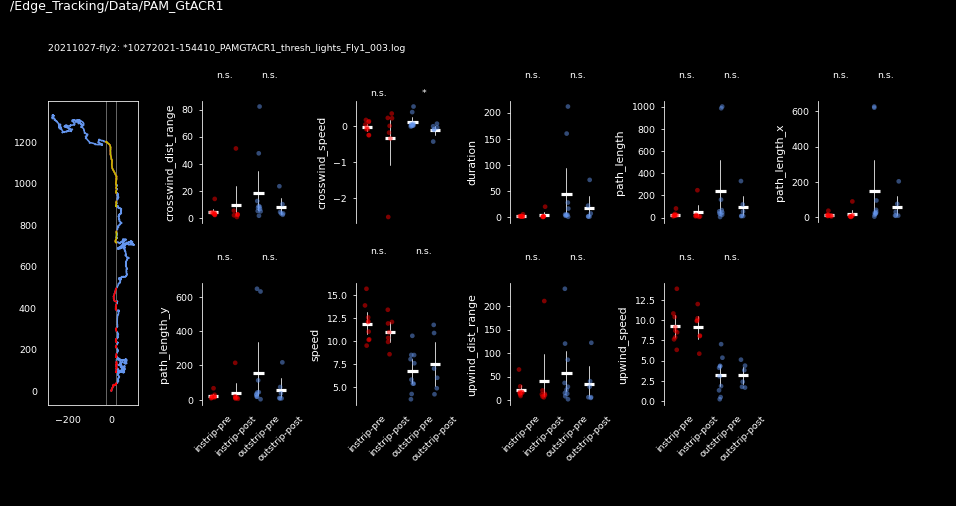

/home/julianarhee/anaconda3/envs/plume/lib/python3.9/site-packages/seaborn/categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0)]) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,
/home/julianarhee/anaconda3/envs/plume/lib/python3.9/site-packages/seaborn/categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0)]) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,
/home/julianarhee/anaconda3/envs/plume/lib/python3.9/site-packages/seaborn/categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0)]) for an unfilled marker ('_').  Matplotlib is ign

<IPython.core.display.Javascript object>


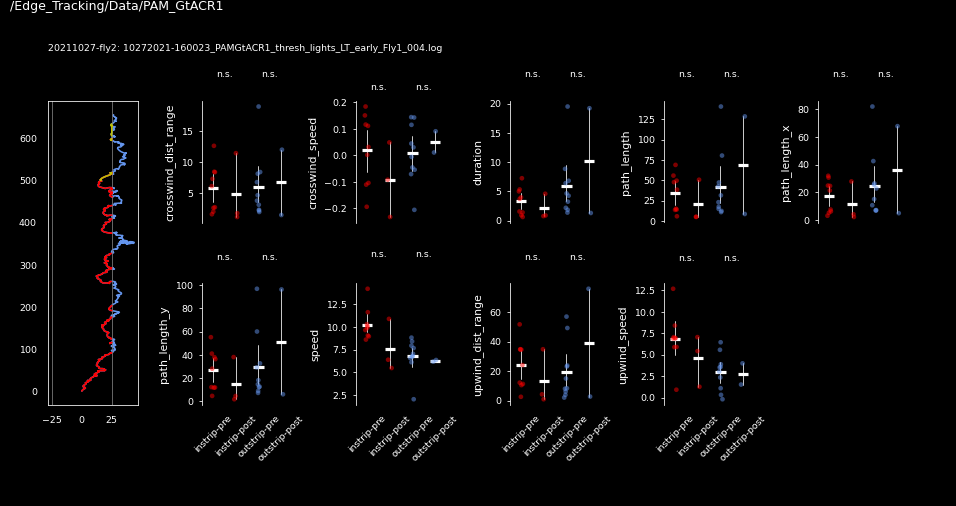

/home/julianarhee/anaconda3/envs/plume/lib/python3.9/site-packages/seaborn/categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0)]) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,
/home/julianarhee/anaconda3/envs/plume/lib/python3.9/site-packages/seaborn/categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0)]) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,
/home/julianarhee/anaconda3/envs/plume/lib/python3.9/site-packages/seaborn/categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0)]) for an unfilled marker ('_').  Matplotlib is ign

<IPython.core.display.Javascript object>


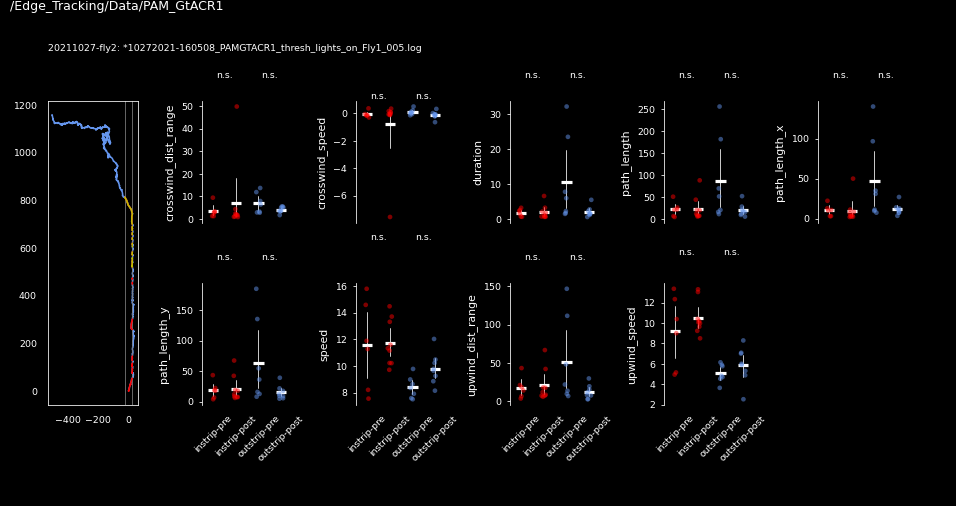

/home/julianarhee/anaconda3/envs/plume/lib/python3.9/site-packages/seaborn/categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0)]) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,
/home/julianarhee/anaconda3/envs/plume/lib/python3.9/site-packages/seaborn/categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0)]) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,
/home/julianarhee/anaconda3/envs/plume/lib/python3.9/site-packages/seaborn/categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0)]) for an unfilled marker ('_').  Matplotlib is ign

<IPython.core.display.Javascript object>


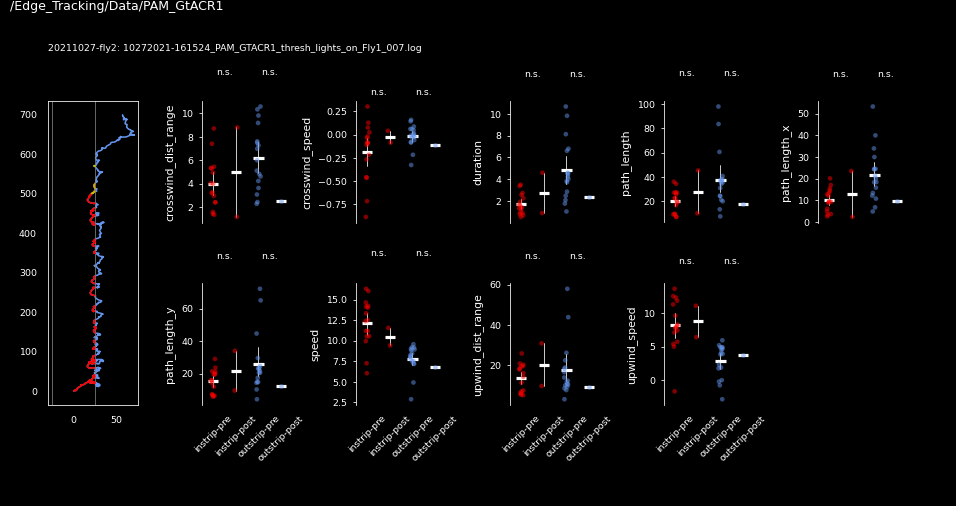

/home/julianarhee/anaconda3/envs/plume/lib/python3.9/site-packages/seaborn/categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0)]) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,
/home/julianarhee/anaconda3/envs/plume/lib/python3.9/site-packages/seaborn/categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0)]) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,
/home/julianarhee/anaconda3/envs/plume/lib/python3.9/site-packages/seaborn/categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0)]) for an unfilled marker ('_').  Matplotlib is ign

<IPython.core.display.Javascript object>


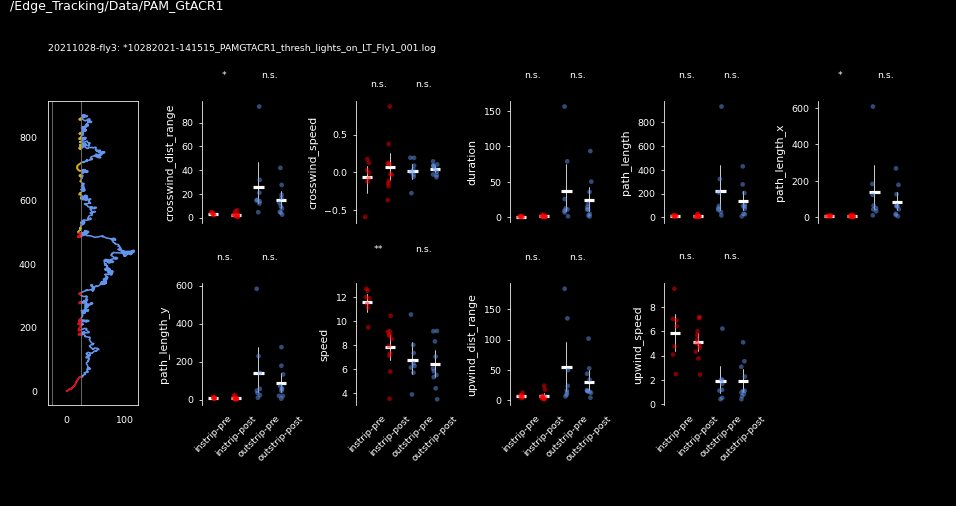

/home/julianarhee/anaconda3/envs/plume/lib/python3.9/site-packages/seaborn/categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0)]) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,
/home/julianarhee/anaconda3/envs/plume/lib/python3.9/site-packages/seaborn/categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0)]) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,
/home/julianarhee/anaconda3/envs/plume/lib/python3.9/site-packages/seaborn/categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0)]) for an unfilled marker ('_').  Matplotlib is ign

<IPython.core.display.Javascript object>


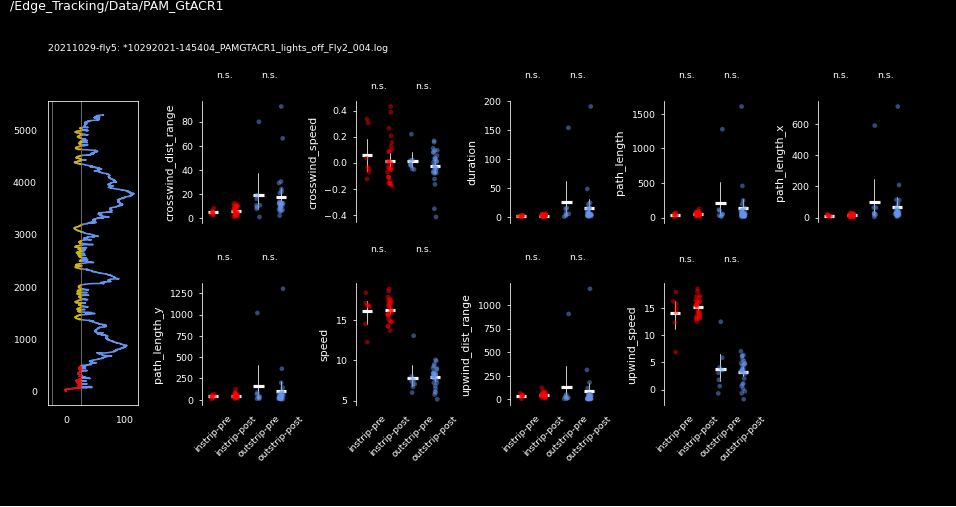

/home/julianarhee/anaconda3/envs/plume/lib/python3.9/site-packages/seaborn/categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0)]) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,
/home/julianarhee/anaconda3/envs/plume/lib/python3.9/site-packages/seaborn/categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0)]) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,
/home/julianarhee/anaconda3/envs/plume/lib/python3.9/site-packages/seaborn/categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0)]) for an unfilled marker ('_').  Matplotlib is ign

<IPython.core.display.Javascript object>


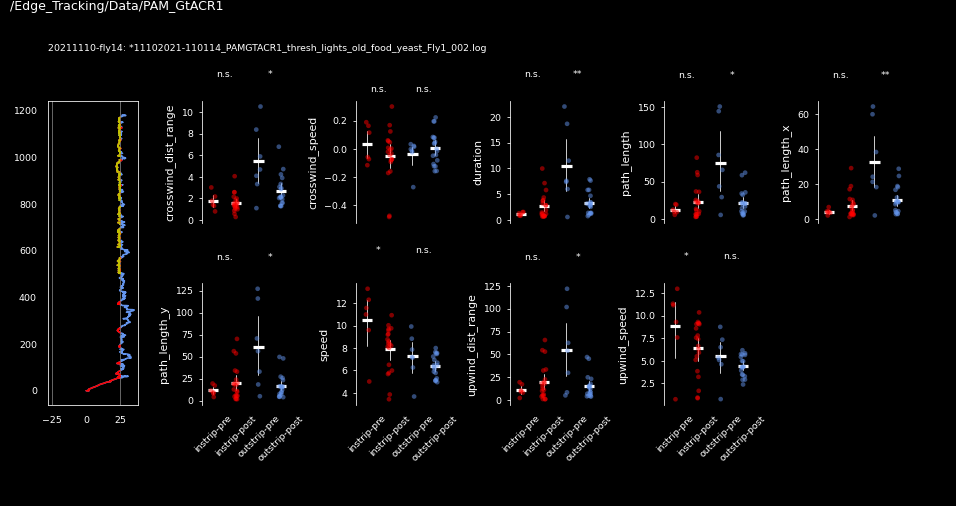

/home/julianarhee/anaconda3/envs/plume/lib/python3.9/site-packages/seaborn/categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0)]) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,
/home/julianarhee/anaconda3/envs/plume/lib/python3.9/site-packages/seaborn/categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0)]) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,
/home/julianarhee/anaconda3/envs/plume/lib/python3.9/site-packages/seaborn/categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0)]) for an unfilled marker ('_').  Matplotlib is ign

<IPython.core.display.Javascript object>


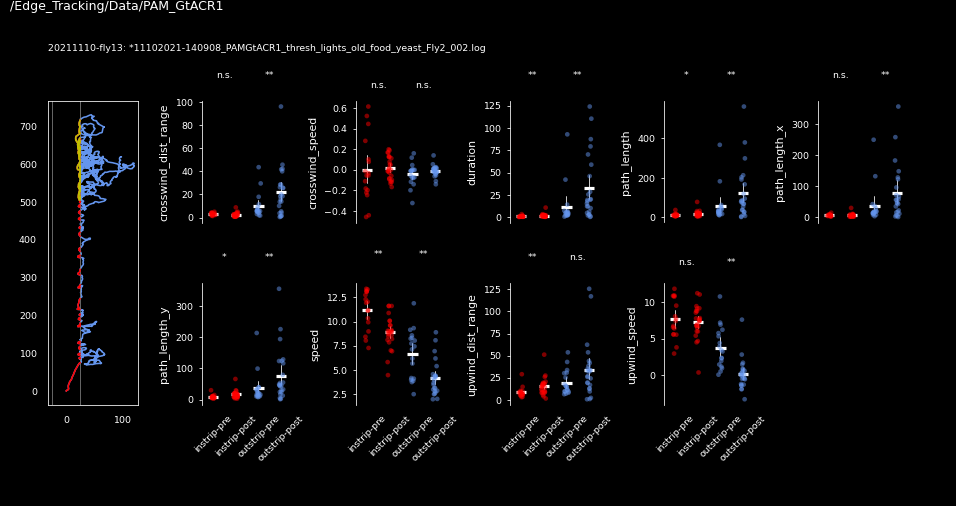

/home/julianarhee/anaconda3/envs/plume/lib/python3.9/site-packages/seaborn/categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0)]) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,
/home/julianarhee/anaconda3/envs/plume/lib/python3.9/site-packages/seaborn/categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0)]) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,
/home/julianarhee/anaconda3/envs/plume/lib/python3.9/site-packages/seaborn/categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0)]) for an unfilled marker ('_').  Matplotlib is ign

<IPython.core.display.Javascript object>


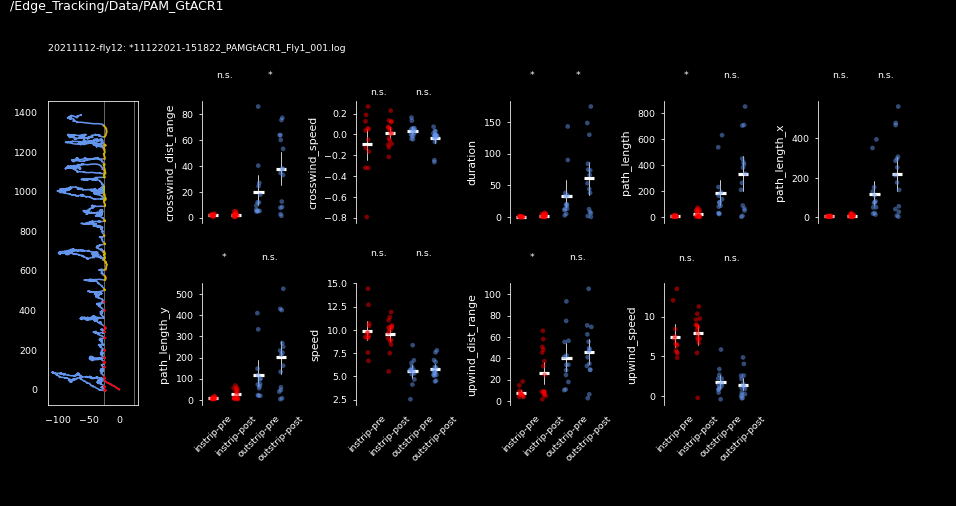

/home/julianarhee/anaconda3/envs/plume/lib/python3.9/site-packages/seaborn/categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0)]) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,
/home/julianarhee/anaconda3/envs/plume/lib/python3.9/site-packages/seaborn/categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0)]) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,
/home/julianarhee/anaconda3/envs/plume/lib/python3.9/site-packages/seaborn/categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0)]) for an unfilled marker ('_').  Matplotlib is ign

<IPython.core.display.Javascript object>


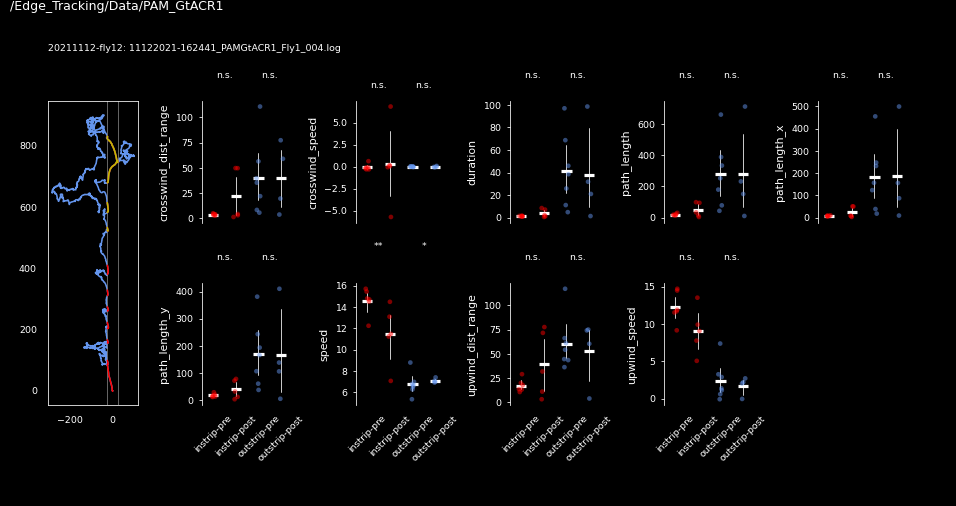

/home/julianarhee/anaconda3/envs/plume/lib/python3.9/site-packages/seaborn/categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0)]) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,
/home/julianarhee/anaconda3/envs/plume/lib/python3.9/site-packages/seaborn/categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0)]) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,
/home/julianarhee/anaconda3/envs/plume/lib/python3.9/site-packages/seaborn/categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0)]) for an unfilled marker ('_').  Matplotlib is ign

<IPython.core.display.Javascript object>


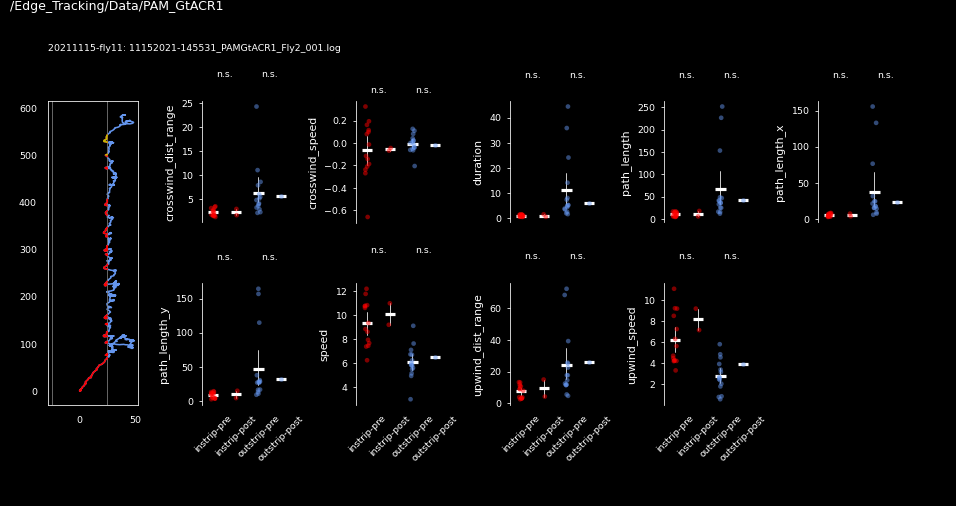

/home/julianarhee/anaconda3/envs/plume/lib/python3.9/site-packages/seaborn/categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0)]) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,
/home/julianarhee/anaconda3/envs/plume/lib/python3.9/site-packages/seaborn/categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0)]) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,
/home/julianarhee/anaconda3/envs/plume/lib/python3.9/site-packages/seaborn/categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0)]) for an unfilled marker ('_').  Matplotlib is ign

<IPython.core.display.Javascript object>


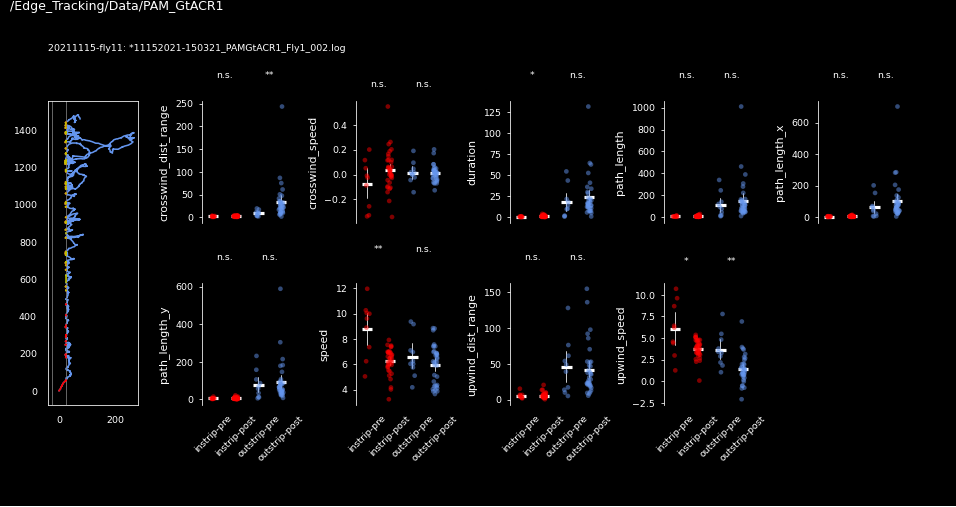

/home/julianarhee/anaconda3/envs/plume/lib/python3.9/site-packages/seaborn/categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0)]) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,
/home/julianarhee/anaconda3/envs/plume/lib/python3.9/site-packages/seaborn/categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0)]) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,
/home/julianarhee/anaconda3/envs/plume/lib/python3.9/site-packages/seaborn/categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0)]) for an unfilled marker ('_').  Matplotlib is ign

<IPython.core.display.Javascript object>


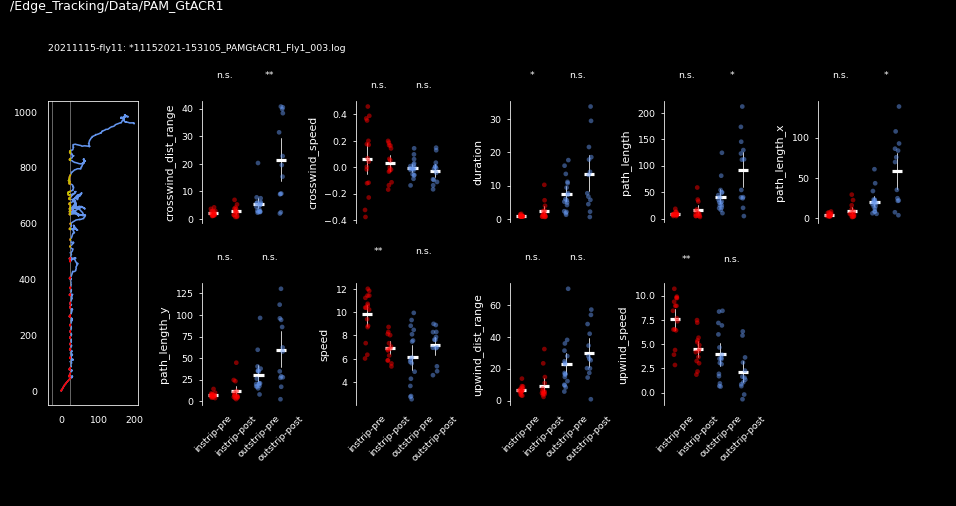

/home/julianarhee/anaconda3/envs/plume/lib/python3.9/site-packages/seaborn/categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0)]) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,
/home/julianarhee/anaconda3/envs/plume/lib/python3.9/site-packages/seaborn/categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0)]) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,
/home/julianarhee/anaconda3/envs/plume/lib/python3.9/site-packages/seaborn/categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0)]) for an unfilled marker ('_').  Matplotlib is ign

<IPython.core.display.Javascript object>


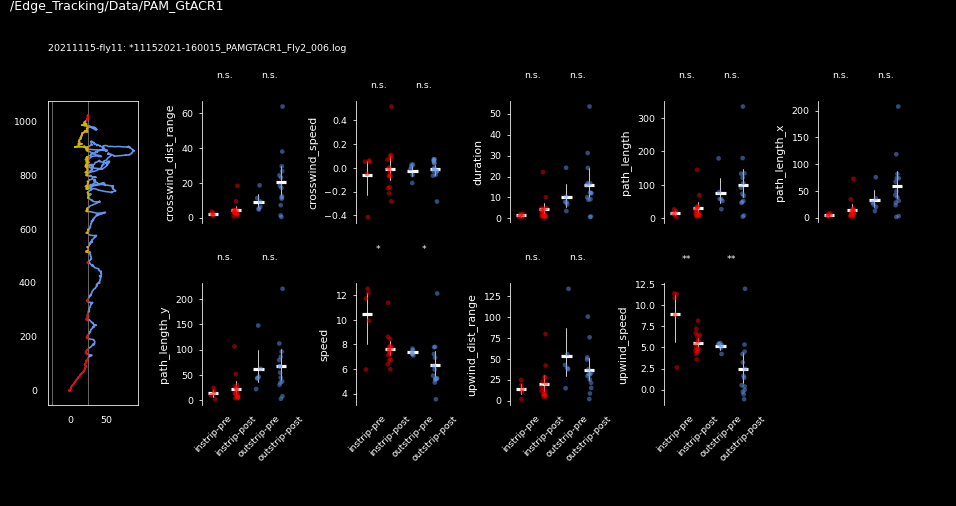

/home/julianarhee/anaconda3/envs/plume/lib/python3.9/site-packages/seaborn/categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0)]) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,
/home/julianarhee/anaconda3/envs/plume/lib/python3.9/site-packages/seaborn/categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0)]) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,
/home/julianarhee/anaconda3/envs/plume/lib/python3.9/site-packages/seaborn/categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0)]) for an unfilled marker ('_').  Matplotlib is ign

<IPython.core.display.Javascript object>


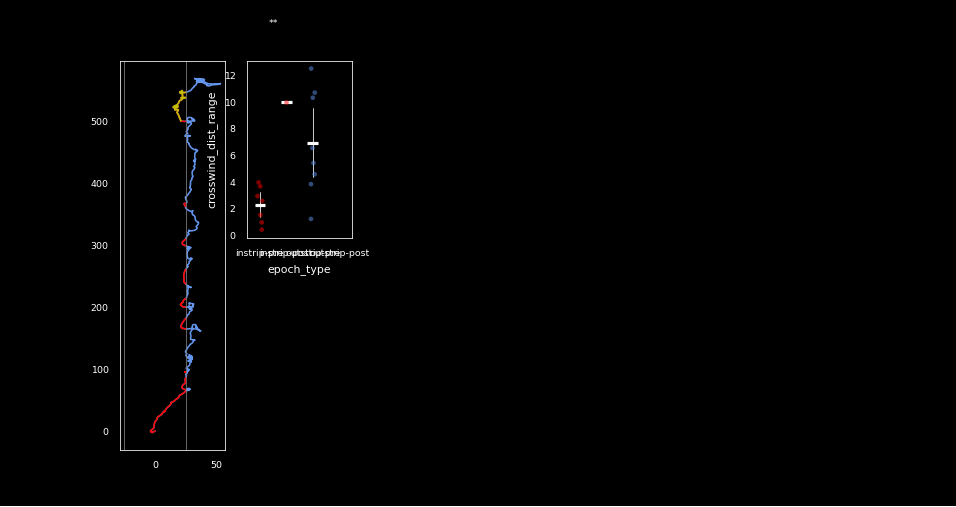

/home/julianarhee/anaconda3/envs/plume/lib/python3.9/site-packages/seaborn/categorical.py:1680: UserWarning: You passed a edgecolor/edgecolors ([(1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0), (1.0, 1.0, 1.0)]) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,


ZeroDivisionError: division by zero

In [1267]:
melt_ = meltdf[meltdf['filename']==fn]
#for 
xorder = ['instrip-pre', 'instrip-post', 'outstrip-pre', 'outstrip-post']
epoch_palette = dict((k, instrip_palette2['instrip']) if 'instrip' in k else (k, instrip_palette2['outstrip']) for k in xorder)

plotvars = yvarnames #yvar='speed'

for fn, melt_ in meltdf.groupby('filename'):
    fly_id = melt_['fly_id'].unique()[0]
    traj_ = etdf1[etdf1['filename']==fn].copy()
    traj_ = putil.zero_trajectory(traj_)

    # fig, axn = pl.subplots(1, len(plotvars)+1, sharex=False, sharey=False, figsize=(8,3.5))
    fig = pl.figure( figsize=(8.5, 4.5))
    nr=2
    nc=6
    gs = mpl.gridspec.GridSpec(nr, nc, figure=fig)

    ax = fig.add_subplot(gs[0:, 0])
    putil.plot_zeroed_trajectory(traj_, ax=ax, bool_colors=bool_colors, bool_vars=bool_vars, traj_lw=1, odor_lw=0.5, main_col='cornflowerblue')

    ci = 0
    ri = 0
    for cond, cond_df in melt_.groupby('variable'):
        ci += 1
        if ci >= nc:
            ci = 1
            ri = 1

        ax=fig.add_subplot(gs[ri, ci])
        sns.pointplot(data=cond_df, x='epoch_type', y='value', order=xorder, ax=ax, 
                      markers='_', color='w', scale=1, errwidth=0.5, join=False) #, jitter=False)
        sns.stripplot(data=cond_df, x='epoch_type', y ='value', order=xorder, 
                      hue='epoch_type', hue_order=xorder, palette=epoch_palette,
                      ax=ax, c='w', s=3, alpha=0.5, jitter=True, legend=0)
        ax.set_ylabel(cond)
        # stats
        for bi, bout in enumerate(['instrip', 'outstrip']):
            a = cond_df[cond_df['epoch_type']=='{}-pre'.format(bout)]['value'].values
            b = cond_df[cond_df['epoch_type']=='{}-post'.format(bout)]['value'].values
            ks = st.ks_2samp(a, b)
            stat_string = 'ks: {:.2f}, p: {:.2f}'.format(ks['ks_stat'], ks['p_value'])
            if ks['p_value']<0.05:
                annot = '**' if ks['p_value']<0.01 else '*'
            else:
                annot='n.s.'
            ax.text(bi*2 + 0.5, ax.get_ylim()[-1]*1.2, annot, fontsize=6, ha='center')
        # axes
        putil.set_outward_spines(ax)
        putil.remove_spines(ax, axes=['right', 'top', 'bottom'])
        if ri==0:
            ax.set_xlabel('')
            ax.set_xticklabels([])
        else:
            ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
            ax.set_xlabel('')

    util.label_figure(fig, fig_id)
    if fn in enough_post_bouts:
        fig.text(0.05, 0.9, '{}: *{}.log'.format(fly_id, fn), fontsize=6)
    else:
        fig.text(0.05, 0.9, '{}: {}.log'.format(fly_id, fn), fontsize=6)
    pl.subplots_adjust(wspace=0.7, hspace=0.5, bottom=0.2, top=0.8, left=0.05, right=0.95)

    pl.savefig(os.path.join(curr_figdir, 'pre-post-silencing_{}'.format(fn)))


# compare PRE vs POST sorted distns

In [1263]:
group_vars = ['fly_id', 'filename', 'epoch', 'bout_type', 'epoch_type']
nbouts = boutdf_filt.groupby(group_vars)['boutnum'].count().reset_index()
durs = boutdf_filt.groupby(group_vars)['duration'].sum().reset_index()
lengths = boutdf_filt.groupby(group_vars)['path_length'].sum().reset_index()

In [1264]:
durlen = pd.merge(nbouts, durs, on=group_vars).merge(lengths, on=group_vars)
durlen['bouts_per_sec'] = durlen['boutnum']/durlen['duration']
durlen['bouts_per_mm'] = durlen['boutnum']/durlen['path_length']

<IPython.core.display.Javascript object>


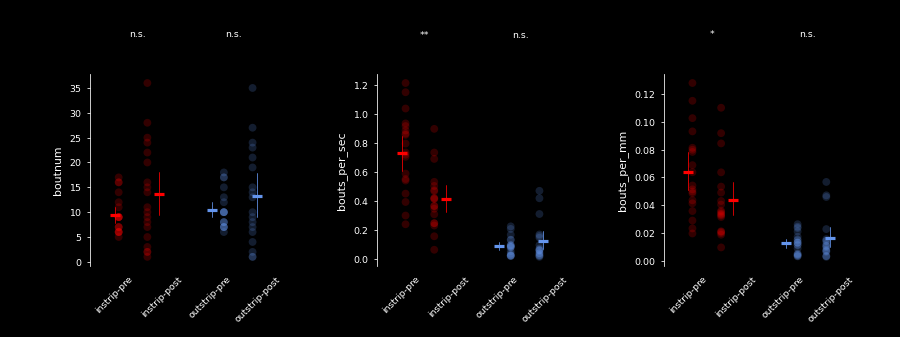

/home/julianarhee/anaconda3/envs/plume/lib/python3.9/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((1.0, 0.0, 0.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/home/julianarhee/anaconda3/envs/plume/lib/python3.9/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.39215686274509803, 0.5843137254901961, 0.9294117647058824)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/home/julianarhee/anaconda3/envs/plume/lib/python3.9/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((1.0, 0.0, 0.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the

In [1265]:
plot_vars = ['boutnum', 'bouts_per_sec', 'bouts_per_mm']
xorder = ['instrip-pre', 'instrip-post', 'outstrip-pre', 'outstrip-post']
epoch_palette = dict((k, instrip_palette2['instrip']) if 'instrip' in k else (k, instrip_palette2['outstrip']) for k in xorder)

fig, axn = pl.subplots(1, len(plot_vars), sharex=True, figsize=(8,3))

for ax, pvar in zip(axn.flat, plot_vars):
    sns.stripplot(data=durlen, x='epoch_type', y=pvar, ax=ax, hue='epoch_type', palette=epoch_palette, 
                  order=xorder, dodge=True, jitter=False , alpha=0.2, legend=0)
    sns.pointplot(data=durlen, x='epoch_type', y=pvar, ax=ax, hue='epoch_type', palette=epoch_palette, 
                  order=xorder, dodge=True, markers='_', color='w', scale=1, errwidth=0.5, join=False)
    ax.legend_.remove()
    ax.set_box_aspect(1)
    ax.set_xlabel('')

    # stats
    for bi, bout in enumerate(['instrip', 'outstrip']):
        a = durlen[durlen['epoch_type']=='{}-pre'.format(bout)][pvar].values
        b = durlen[durlen['epoch_type']=='{}-post'.format(bout)][pvar].values
        ks = st.ks_2samp(a, b)
        stat_string = 'ks: {:.2f}, p: {:.2f}'.format(ks['ks_stat'], ks['p_value'])
        if ks['p_value']<0.05:
            annot = '**' if ks['p_value']<0.01 else '*'
        else:
            annot='n.s.'
        ax.text(bi*2 + 0.5, ax.get_ylim()[-1]*1.2, annot, fontsize=6, ha='center')
    # axes
    putil.set_outward_spines(ax)
    putil.remove_spines(ax, axes=['right', 'top', 'bottom'])

    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
    ax.set_xlabel('')
            
    
pl.subplots_adjust(left=0.1, right=0.95, wspace=0.50)

In [782]:
importlib.reload(putil)

<module 'plotting' from '/home/julianarhee/Repositories/plume-tracking/plotting.py'>

/home/julianarhee/Repositories/plume-tracking/plotting.py:200: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  nbins = 20 if varn=='path length' else 200 #if


<IPython.core.display.Javascript object>


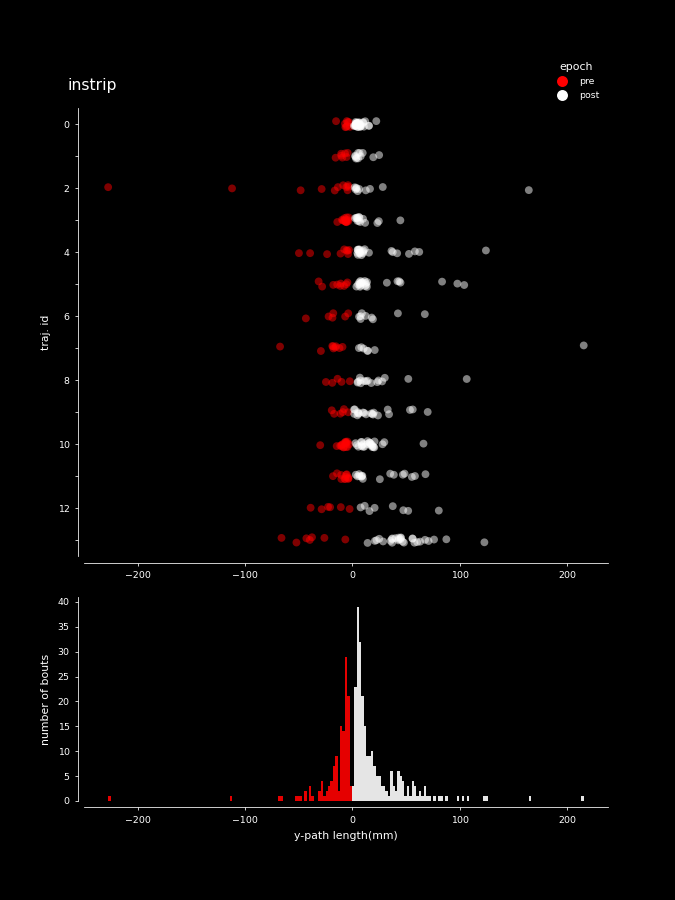

/home/julianarhee/Repositories/plume-tracking/plotting.py:230: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xlabel(xlabel)
/home/julianarhee/Repositories/plume-tracking/plotting.py:200: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  nbins = 20 if varn=='path length' else 200 #if


<IPython.core.display.Javascript object>


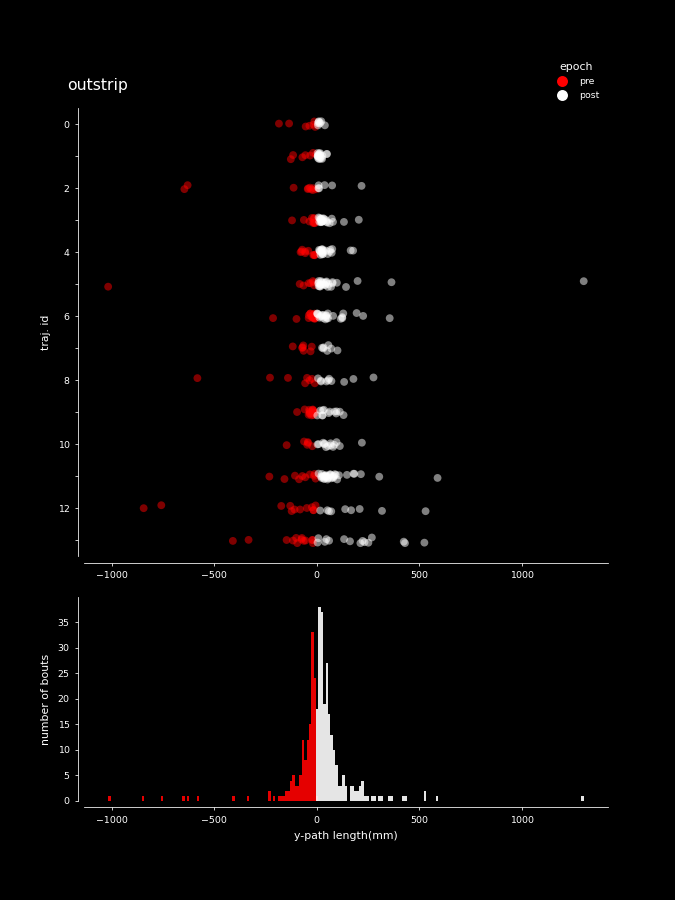

/home/julianarhee/Repositories/plume-tracking/plotting.py:230: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xlabel(xlabel)


Text(0.1, 0.9, 'outstrip')

In [1250]:
yvar = 'path_length_y'
plotdf = boutdf_filt[boutdf_filt['filename'].isin(enough_post_bouts)].copy()

plotdf = putil.flip_data_for_abutting_hists(plotdf, hue='epoch', hue_values=['pre', 'post'])

fig = putil.plot_sorted_distn_with_hist(yvar, plotdf[plotdf['instrip']],
                                        hue='epoch', hue_values=['pre', 'post'], hue_colors=['r', 'w'])
fig.text(0.1, 0.9, 'instrip')

fig = putil.plot_sorted_distn_with_hist(yvar, plotdf[~plotdf['instrip']], 
                                        hue='epoch', hue_values=['pre', 'post'], hue_colors=['r', 'w'])
fig.text(0.1, 0.9, 'outstrip')

In [714]:
mean_boutdf.columns

Index(['filename', 'fly_name', 'instrip', 'condition', 'bout_type', 'epoch',
       'duration', 'upwind_dist_range', 'upwind_dist_firstlast',
       'crosswind_dist_range', 'crosswind_dist_firstlast', 'path_length',
       'path_length_x', 'path_length_y', 'rel_time', 'n_frames',
       'average_ft_heading', 'speed', 'upwind_speed', 'crosswind_speed',
       'date', 'odor_on', 'led_on', 'boutnum', 'sig_status'],
      dtype='object')

In [ ]:
etdf_long = etdf1[etdf1['filename'].isin(enough_post_bouts)].copy()
etdf_long['filename'].unique()


<IPython.core.display.Javascript object>


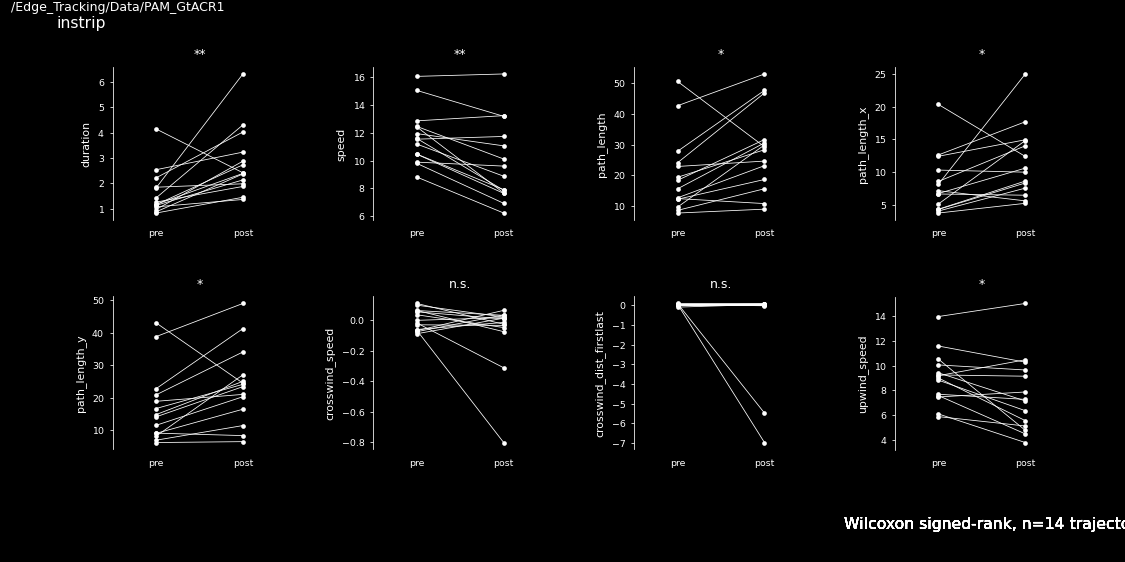

/home/julianarhee/Repositories/plume-tracking/plotting.py:134: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_title(star, fontsize=8)
/home/julianarhee/Repositories/plume-tracking/plotting.py:134: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_title(star, fontsize=8)
/home/julianarhee/Repositories/plume-tracking/plotting.py:134: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_title(star, fontsize=8)
/home/julianarhee/Repositories/plume-tracking/plotting.py:134: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_title(star, fontsize=8)
/home/julianarhee/Repositories/plume-tracking/plotting.py:134: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_title(star, fontsize=8)
/home/julianarhee/Repositories/plume-tracking/plotting.py:134: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.se

<IPython.core.display.Javascript object>


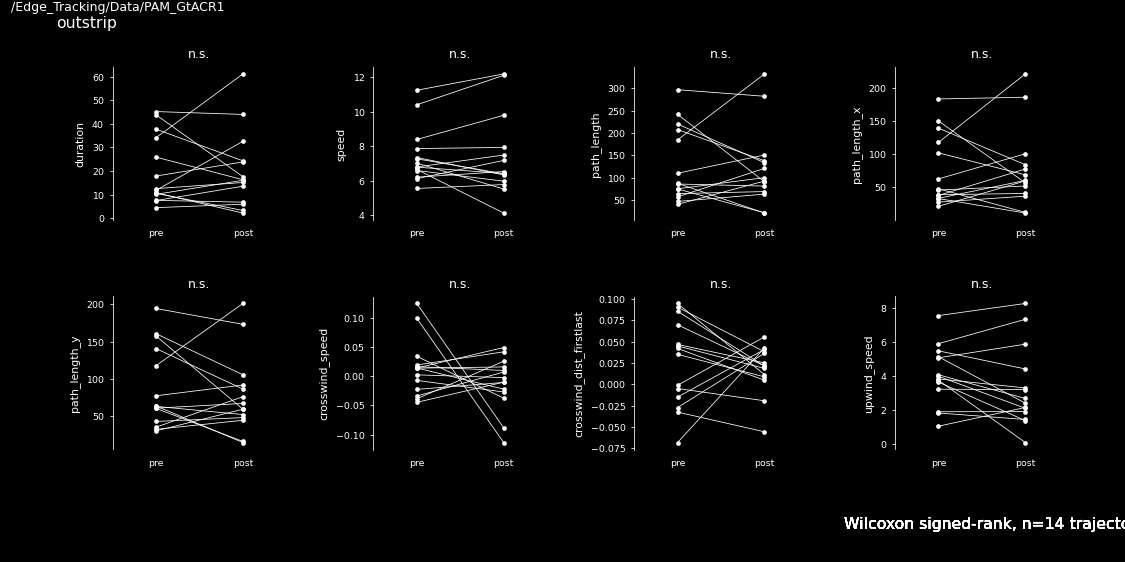

/home/julianarhee/Repositories/plume-tracking/plotting.py:134: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_title(star, fontsize=8)
/home/julianarhee/Repositories/plume-tracking/plotting.py:134: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_title(star, fontsize=8)
/home/julianarhee/Repositories/plume-tracking/plotting.py:134: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_title(star, fontsize=8)
/home/julianarhee/Repositories/plume-tracking/plotting.py:134: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_title(star, fontsize=8)
/home/julianarhee/Repositories/plume-tracking/plotting.py:134: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_title(star, fontsize=8)
/home/julianarhee/Repositories/plume-tracking/plotting.py:134: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.se

In [1266]:
yvarnames = ['duration',  'speed','path_length', 
            'path_length_x', 'path_length_y',
            'crosswind_speed', 'crosswind_dist_firstlast', 
            'upwind_speed', 'upwind_dist_range']

mean_boutdf_long = mean_boutdf[mean_boutdf['filename'].isin(enough_post_bouts)].copy()

conds = ['instrip', 'outstrip']
dfs = [mean_boutdf_long[mean_boutdf_long['instrip']], mean_boutdf_long[~mean_boutdf_long['instrip']]]

for currcond, df_ in zip(conds, dfs):

    fig = putil.plot_paired_inout_metrics(df_, xvarname='epoch', nr=2, nc=4,
                                          yvarnames=yvarnames, xticklabels=['pre', 'post'], order=['pre', 'post'])
    util.label_figure(fig, fig_id)
    fig.text(0.05, 0.95, currcond, fontsize=10)

#     figname = 'summary-metrics-{}-n{}_filt'.format(currcond, len(ets))
#     pl.savefig(os.path.join(curr_figdir, '{}.png'.format(figname)))
#     pl.savefig(os.path.join(curr_figdir, '{}.svg'.format(figname)))
#     print(figname)

In [1184]:
etdf_long[etdf_long['epoch']=='post'].groupby('filename').first()[['boutnum', 'instrip']]

boutnum  instrip
filename                                                            
10272021-154410_PAMGTACR1_thresh_lights_Fly1_003         22     True
10272021-160508_PAMGTACR1_thresh_lights_on_Fly1...       16     True
10282021-141515_PAMGTACR1_thresh_lights_on_LT_F...       18     True
10292021-145404_PAMGTACR1_lights_off_Fly2_004            18     True
11102021-110114_PAMGTACR1_thresh_lights_old_foo...       16     True
11102021-140908_PAMGtACR1_thresh_lights_old_foo...       38     True
11122021-151822_PAMGtACR1_Fly1_001                       28     True
11152021-150321_PAMGtACR1_Fly1_002                       22     True
11152021-153105_PAMGtACR1_Fly1_003                       36     True
11152021-160015_PAMGTACR1_Fly2_006                       14     True
11152021-162717_PAMGtACR1_Fly2_008                       16     True
11162021-104332_PAMGTACR1_Fly1_001                       22     True
11162021-105012_PAMGtACR1_Fly1_002                       22     True
11182021-123116_PAMGtACR1_Fly1_001                       26     True

# plot average bouts

In [1206]:
importlib.reload(traj)

<module 'trajectory' from '/home/julianarhee/Repositories/plume-tracking/trajectory.py'>

In [1211]:
# fn = '11102021-140908_PAMGtACR1_thresh_lights_old_food_yeast_Fly2_002'
fn = '11102021-110114_PAMGTACR1_thresh_lights_old_food_yeast_Fly1_002'
trialdf = etdf_long[etdf_long['filename']==fn].copy()

In [1231]:
xvar='ft_posx'
yvar='ft_posy'

curr_figdir

'/home/julianarhee/edgetracking-googledrive/Edge_Tracking/Data/jyr/PAM_GtACR1/figures/ets/by-individual'

In [1270]:
pre_color = 'w'
post_color='g'

epoch_palette = {'pre': 'w', 'post': 'g'}

In [1271]:
fn = '10272021-154410_PAMGTACR1_thresh_lights_Fly1_003'
trialdf = etdf_long[etdf_long['filename']==fn].copy()


<IPython.core.display.Javascript object>


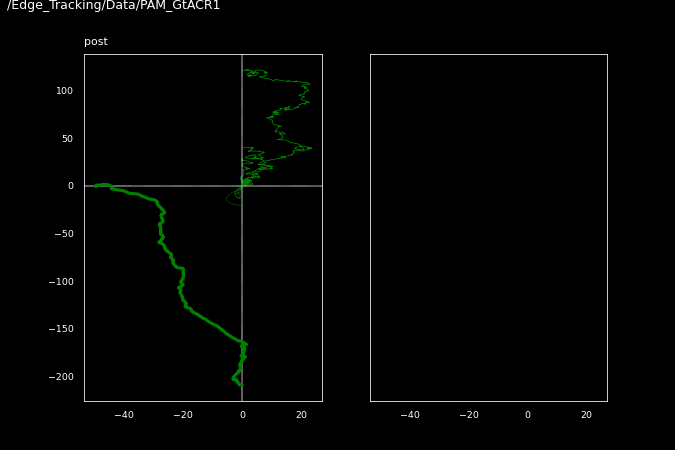

In [1285]:

fig, axn = pl.subplots(1, 2, sharex=True, sharey=True, figsize=(6,4)) # figsize=(8,8))
ai = 0

cond = 'post'
epoch_df = trialdf[trialdf['epoch']==cond].copy()

first_bout = epoch_df[epoch_df['instrip']]['boutnum'].min() #+ 1
if cond=='pre':
    # skip 1st starting instrip, and include last OUTSTRIP only
    first_bout = epoch_df[epoch_df['instrip']]['boutnum'].min()+1
    last_bout = epoch_df[~epoch_df['instrip']]['boutnum'].max() 
else:
    # first POST bout is instrip (by definition, led_on=True), 
    # so skip 1st starting instrip, and include last INSTRIP only
    first_bout = epoch_df[epoch_df['instrip']]['boutnum'].min() #+ 1
    last_bout = epoch_df[epoch_df['instrip']]['boutnum'].max() 

df_ = epoch_df[(epoch_df['boutnum']>=first_bout) & (epoch_df['boutnum']<=last_bout)].copy()
up_ = traj.upsample_trajectory(df_, max_nframes)
ax=axn[ai]
outbouts = up_[~up_['instrip']].copy()
for bnum, curr_outbout in outbouts.groupby('boutnum'):
    curr_inbout = up_[up_['boutnum']==bnum-1].copy().dropna()
    if curr_inbout.shape[0]==0:
        print("no inbout:", bnum)
        continue
    # plot previous outbout
    ax.plot(curr_inbout['ft_posx'], #-inbout['ft_posx_start0'].iloc[-1], 
            curr_inbout['ft_posy']-curr_inbout['ft_posy'].iloc[-1], lw=lw, color=epoch_palette[cond])
    # plot current outbout starting at 0
    ax.plot(curr_outbout['ft_posx'],
            curr_outbout['ft_posy'], lw=0.5, color=epoch_palette[cond])

    ax.axhline(y=0, linestyle=':', color='w', lw=0.25)
    ax.axvline(x=0, linestyle=':', color='w', lw=0.25)

avgx = up_.groupby(['instrip', 'ix'])['ft_posx'].mean().reset_index()#.dropna()
avgy = up_.groupby(['instrip', 'ix'])['ft_posy'].mean().reset_index()#.dropna()

ax.plot(avgx[avgx['instrip']]['ft_posx'], 
        avgy[avgy['instrip']]['ft_posy'] - avgy[avgy['instrip']]['ft_posy'].dropna().iloc[-1], 
        lw=2, color=epoch_palette[cond], alpha=1)
# ax.plot(avgx[~avgx['instrip']]['ft_posx'], 
#         avgy[~avgy['instrip']]['ft_posy'] - avgy[avgy['instrip']]['ft_posy'].dropna().iloc[0], 
#         lw=2, color=epoch_palette[cond], alpha=1)
ax.set_title(cond, loc='left')
util.label_figure(fig, fig_id)

In [1279]:
up_[up_['instrip']]['boutnum']

0         22
1         22
2         22
3         22
4         22
          ..
100160    34
100161    34
100162    34
100163    34
100164    34
Name: boutnum, Length: 53935, dtype: int64

<IPython.core.display.Javascript object>


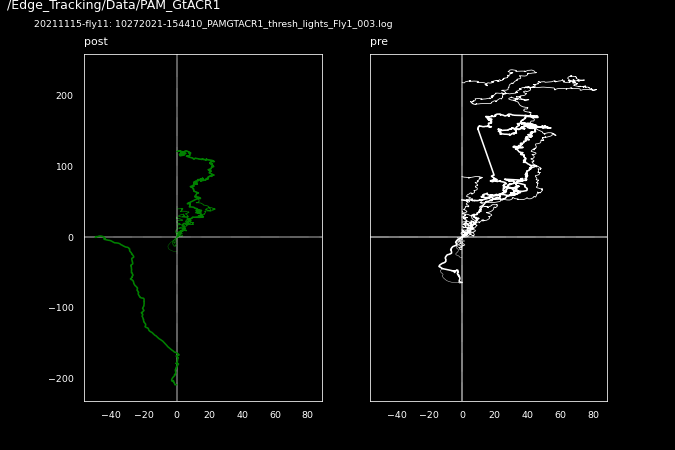

no inbout: 3


<IPython.core.display.Javascript object>


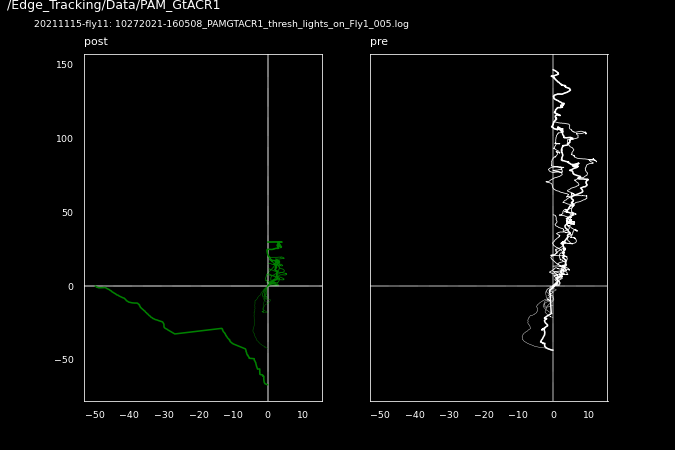

no inbout: 3


<IPython.core.display.Javascript object>


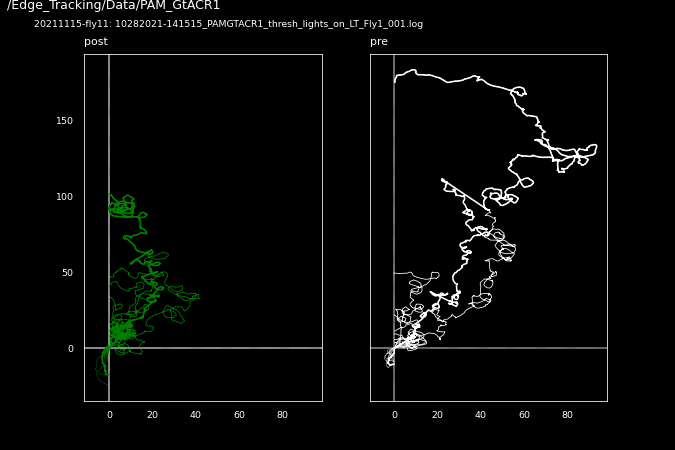

no inbout: 3


<IPython.core.display.Javascript object>


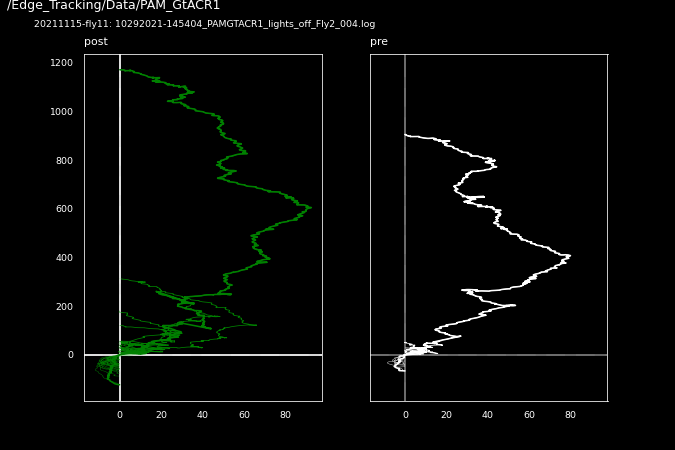

no inbout: 3


<IPython.core.display.Javascript object>


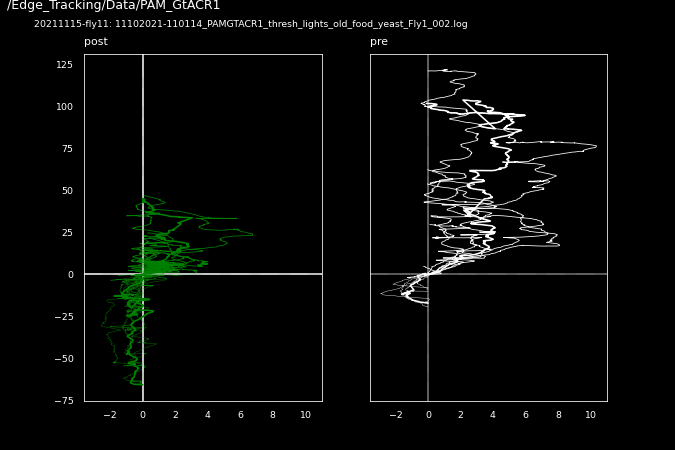

no inbout: 3


<IPython.core.display.Javascript object>


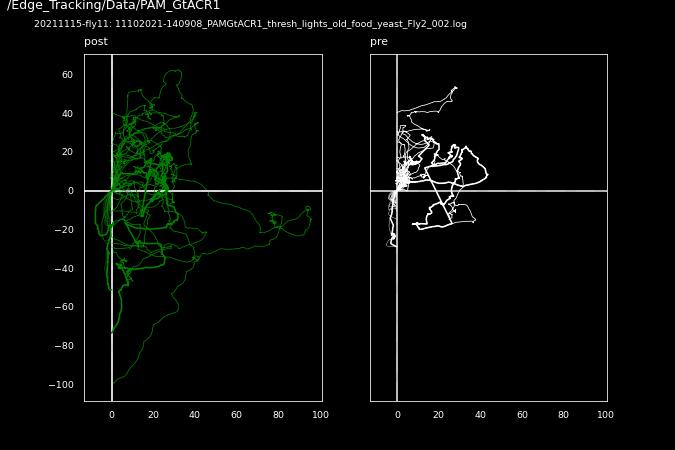

no inbout: 3


<IPython.core.display.Javascript object>


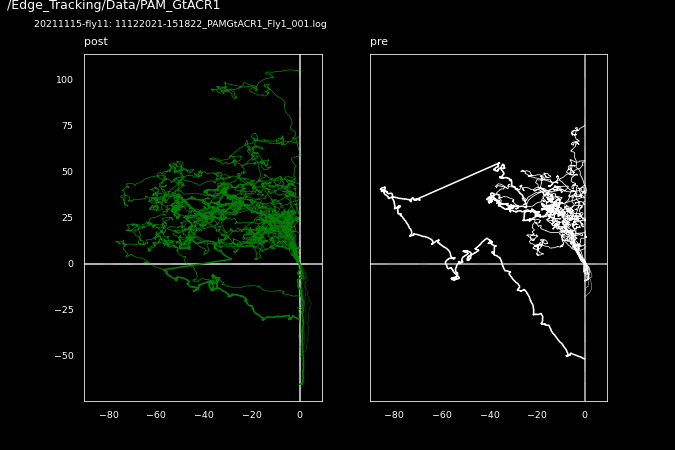

no inbout: 3


<IPython.core.display.Javascript object>


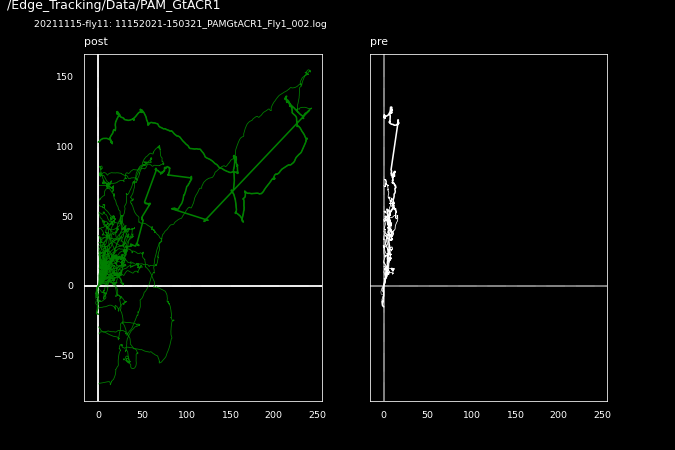

no inbout: 3


<IPython.core.display.Javascript object>


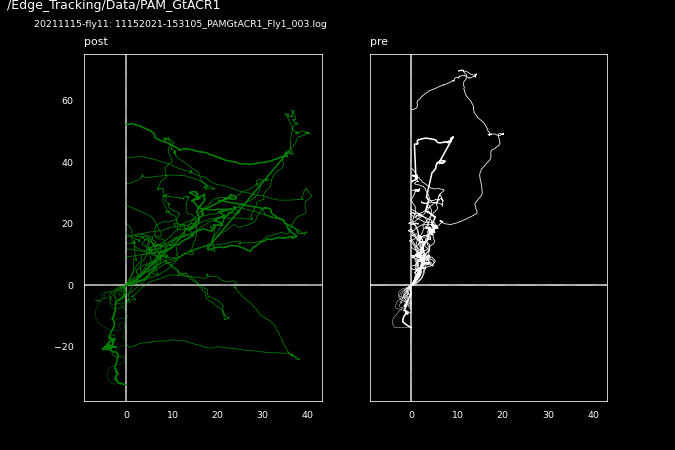

no inbout: 3


<IPython.core.display.Javascript object>


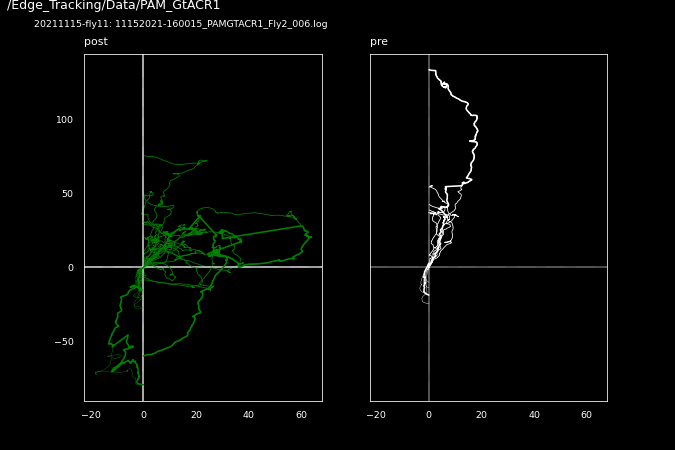

no inbout: 3


<IPython.core.display.Javascript object>


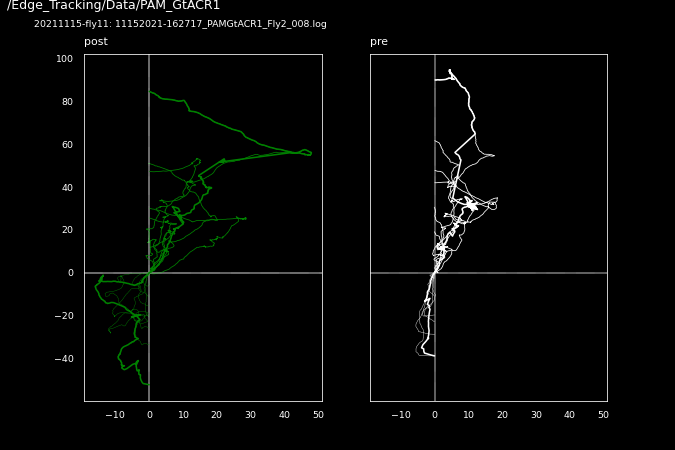

no inbout: 3


<IPython.core.display.Javascript object>


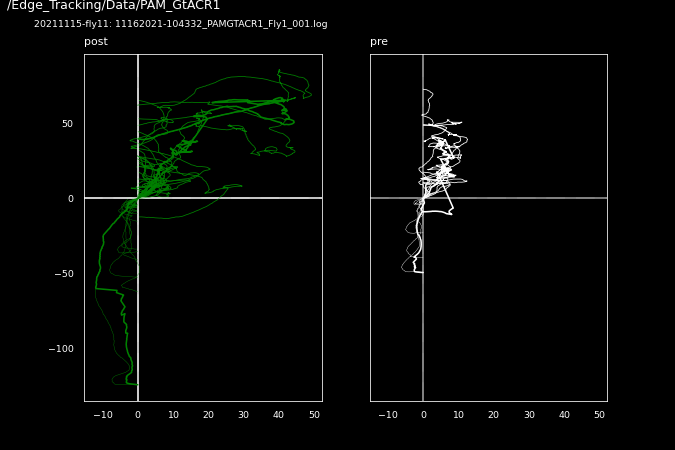

no inbout: 3


<IPython.core.display.Javascript object>


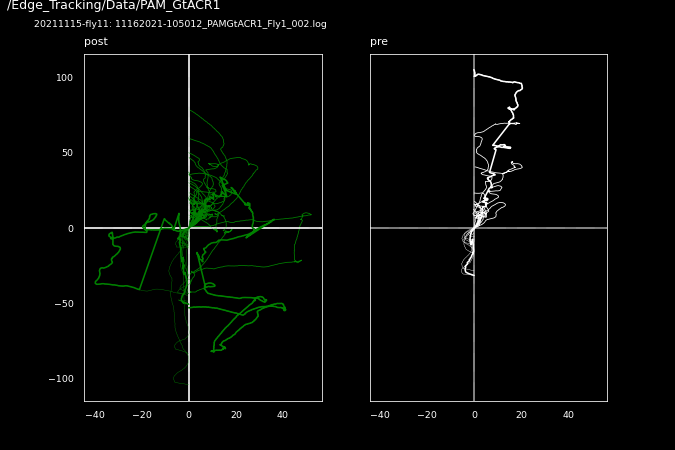

no inbout: 3


<IPython.core.display.Javascript object>


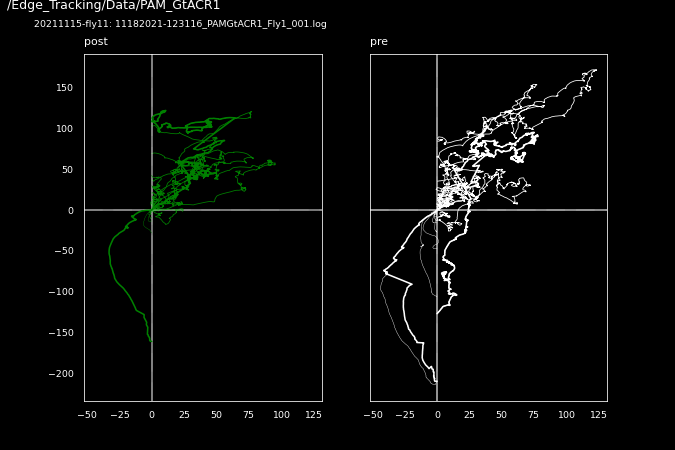

no inbout: 3


In [1234]:
lw=0.25
avg_lw=1
for fn, trialdf in etdf_long.groupby('filename'):
    max_nframes = boutdf_filt[boutdf_filt['filename']==fn]['n_frames'].max()
    
    fig, axn = pl.subplots(1, 2, sharex=True, sharey=True, figsize=(6,4)) # figsize=(8,8))
    ai = 0
    for cond, epoch_df in trialdf.groupby('epoch'):

        first_bout = epoch_df[epoch_df['instrip']]['boutnum'].min() #+ 1
        if cond=='pre':
            # skip 1st starting instrip, and include last OUTSTRIP only
            first_bout = epoch_df[epoch_df['instrip']]['boutnum'].min()+1
            last_bout = epoch_df[~epoch_df['instrip']]['boutnum'].max() 
        else:
            # first POST bout is instrip (by definition, led_on=True), 
            # so skip 1st starting instrip, and include last INSTRIP only
            first_bout = epoch_df[epoch_df['instrip']]['boutnum'].min() #+ 1
            last_bout = epoch_df[epoch_df['instrip']]['boutnum'].max() 

        df_ = epoch_df[(epoch_df['boutnum']>=first_bout) & (epoch_df['boutnum']<=last_bout)].copy()
        up_ = traj.upsample_trajectory(df_, max_nframes)
        ax=axn[ai]
        outbouts = up_[~up_['instrip']].copy()
        for bnum, curr_outbout in outbouts.groupby('boutnum'):
            curr_inbout = up_[up_['boutnum']==bnum-1].copy().dropna()
            if curr_inbout.shape[0]==0:
                print("no inbout:", bnum)
                continue
            # plot previous outbout
            ax.plot(curr_inbout['ft_posx'], #-inbout['ft_posx_start0'].iloc[-1], 
                    curr_inbout['ft_posy']-curr_inbout['ft_posy'].iloc[-1], lw=lw, color=epoch_palette[cond])
            # plot current outbout starting at 0
            ax.plot(curr_outbout['ft_posx'],
                    curr_outbout['ft_posy'], lw=0.5, color=epoch_palette[cond])

            ax.axhline(y=0, linestyle=':', color='w', lw=0.25)
            ax.axvline(x=0, linestyle=':', color='w', lw=0.25)

        avgx = up_.groupby(['instrip', 'ix'])['ft_posx'].mean().reset_index()#.dropna()
        avgy = up_.groupby(['instrip', 'ix'])['ft_posy'].mean().reset_index()#.dropna()

        ax.plot(avgx[avgx['instrip']]['ft_posx'], 
                avgy[avgy['instrip']]['ft_posy'] - avgy[avgy['instrip']]['ft_posy'].dropna().iloc[-1], 
                lw=avg_lw, color=epoch_palette[cond], alpha=1)
        ax.plot(avgx[~avgx['instrip']]['ft_posx'], 
                avgy[~avgy['instrip']]['ft_posy'] - avgy[avgy['instrip']]['ft_posy'].dropna().iloc[0], 
                lw=avg_lw, color=epoch_palette[cond], alpha=1)
        ax.set_title(cond, loc='left')
        ai+=1

    util.label_figure(fig, fig_id)

    fig.text(0.05, 0.94, '{}: {}.log'.format(fly_id, fn), fontsize=6)
    
    pl.savefig(os.path.join(curr_figdir, 'avgbout_{}.png'.format(fn)))
    #pl.subplots_adjust(wspace=0.7, hspace=0.5, bottom=0.2, top=0.8, left=0.05, right=0.95)

In [881]:
import pingouin as pg

ModuleNotFoundError: No module named 'pingouin'

In [294]:
import seaborn as sns